# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data\train.tsv is already downloaded.
File data\validation.tsv is already downloaded.
File data\test.tsv is already downloaded.
File data\text_prepare_tests.tsv is already downloaded.


### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [2]:
from grader import Grader

In [3]:
grader = Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cagri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train.head()

title                  tags
0                How to draw a stacked dotplot in R?                   [r]
1  mysql select all records where a datetime fiel...          [php, mysql]
2             How to terminate windows phone 8.1 app                  [c#]
3  get current time in a specific country via jquery  [javascript, jquery]
4                      Configuring Tomcat to Use SSL                [java]

As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [11]:
X_train.shape[:]

(100000,)

In [12]:
X_train[0]

'How to draw a stacked dotplot in R?'

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [13]:
import re

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [15]:
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = text.split()
    text = [word for word in text if word not in STOPWORDS]
    text = " ".join(i for i in text)
    return text

## Testing the text_prepare function

In [16]:
etc = r"A[ny te\xt CAN b`e this t]o the way"

In [17]:
etc = etc.lower()
etc

'a[ny te\\xt can b`e this t]o the way'

In [18]:
etc = re.sub(REPLACE_BY_SPACE_RE," ",etc)
etc

'a ny te\\xt can b`e this t o the way'

In [19]:
etc = re.sub(BAD_SYMBOLS_RE,"",etc)
etc

'a ny text can be this t o the way'

In [20]:
etc = etc.split();
etc

['a', 'ny', 'text', 'can', 'be', 'this', 't', 'o', 'the', 'way']

In [21]:
etc = [word for word in etc if word not in STOPWORDS]
etc

['ny', 'text', 'way']

In [22]:
etc = " ".join(i for i in etc)
etc

'ny text way'

<div class="alert alert-block alert-success">
<b>ATTENTION:</b> ---- TEST END ---- TEST END ---- TEST END ---- TEST END ----
</div>

---

In [300]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [301]:
print(test_text_prepare())

Basic tests are passed.


---

Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [391]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [303]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [304]:
X_train[:5]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl']

---

---

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [63]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

In [64]:
def words_counts_func(text):
    
    j = []
    test_list = []

    for i in text:
        j.append(i.split(" "))

    for k in j:
        for l in k:
            test_list.append(l)
        

    from collections import Counter

    words_counts = Counter(test_list)
    return words_counts

## Illustration of word_counts_func

In [65]:
j = []
test_list = []

for i in X_train:
    j.append(i.split(" "))

for k in j:
    for l in k:
        test_list.append(l)
        
test_list[:5]

['draw', 'stacked', 'dotplot', 'r', 'mysql']

<div class="alert alert-block alert-success">
<b>ATTENTION:</b> ---- TEST END ---- TEST END ---- TEST END ---- TEST END ----
</div>

---

In [66]:
def tag_counts_func(text):
    
    frequency_counter = []

    for i in text:
        for j in i:
            frequency_counter.append(j)

    tags_counts = Counter(frequency_counter)
    return tags_counts

## Illustration of tag_counts_func

In [67]:
train["tags"][:5]

0                     [r]
1            [php, mysql]
2                    [c#]
3    [javascript, jquery]
4                  [java]
Name: tags, dtype: object

In [68]:
frequency_counter = []

for i in train["tags"]:
    print(i) # reveals tags for a single question
    for j in i:
        print(j) # As there are more than one tag for a question, this loop gets the tags from questions that have multiple tags
        frequency_counter.append(j)

tags_counts = Counter(frequency_counter)

['r']
r
['php', 'mysql']
php
mysql
['c#']
c#
['javascript', 'jquery']
javascript
jquery
['java']
java
['ruby-on-rails']
ruby-on-rails
['ruby', 'ruby-on-rails-3', 'json']
ruby
ruby-on-rails-3
json
['ruby']
ruby
['java', 'spring', 'spring-mvc']
java
spring
spring-mvc
['php', 'codeigniter']
php
codeigniter
['java', 'class']
java
class
['javascript', 'jquery', 'html', 'ios']
javascript
jquery
html
ios
['javascript', 'jquery']
javascript
jquery
['c++', 'eclipse']
c++
eclipse
['javascript']
javascript
['python', 'list']
python
list
['ios', 'objective-c']
ios
objective-c
['ios', 'json', 'swift']
ios
json
swift
['c#', 'xaml']
c#
xaml
['c#', 'asp.net']
c#
asp.net
['c#', 'wpf', 'multithreading']
c#
wpf
multithreading
['python', 'ruby']
python
ruby
['php', 'image', 'codeigniter']
php
image
codeigniter
['java', 'performance']
java
performance
['javascript', 'jquery', 'twitter-bootstrap']
javascript
jquery
twitter-bootstrap
['c#', 'linq']
c#
linq
['python', 'xml']
python
xml
['c#']
c#
['python']
py

javascript
node.js
['ruby-on-rails']
ruby-on-rails
['php', 'wordpress']
php
wordpress
['ios', 'xcode', 'swift']
ios
xcode
swift
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['php']
php
['c#', 'wpf']
c#
wpf
['c']
c
['javascript']
javascript
['javascript', 'image', 'node.js']
javascript
image
node.js
['java']
java
['php']
php
['javascript', 'dom']
javascript
dom
['java']
java
['c#', '.net', 'unit-testing']
c#
.net
unit-testing
['python']
python
['php']
php
['vb.net']
vb.net
['ios', 'objective-c', 'uitableview']
ios
objective-c
uitableview
['c#', 'linq']
c#
linq
['c']
c
['c#', 'asp.net']
c#
asp.net
['c#', 'wpf']
c#
wpf
['ruby-on-rails']
ruby-on-rails
['php']
php
['c#', 'visual-studio-2010']
c#
visual-studio-2010
['java', 'android', 'xml']
java
android
xml
['c#', 'winforms']
c#
winforms
['java', 'swing']
java
swing
['c#', 'asp.net', 'winforms']
c#
asp.net
winforms
['php', 'jquery', 'ajax']
php
jquery
ajax
['php']
php
['php', 'javascript', 'html', 'jsp', 'jquery']
php
javascript
html
jsp
jq

['python']
python
['c#', 'json']
c#
json
['r', 'excel']
r
excel
['c++', 'c']
c++
c
['c++', 'opencv']
c++
opencv
['java']
java
['ruby']
ruby
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['sql', 'vb.net']
sql
vb.net
['javascript']
javascript
['c', 'objective-c']
c
objective-c
['c++']
c++
['java', 'android', 'json']
java
android
json
['ruby']
ruby
['php']
php
['c']
c
['r', 'loops']
r
loops
['javascript', 'asp.net-mvc']
javascript
asp.net-mvc
['python']
python
['php', 'oop']
php
oop
['javascript', 'jquery']
javascript
jquery
['php']
php
['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['python', 'string', 'python-2.7']
python
string
python-2.7
['c#']
c#
['python', 'numpy']
python
numpy
['python']
python
['javascript', 'jquery', 'html']
javascript
jquery
html
['python', 'python-2.7']
python
python-2.7
['c#', '.net']
c#
.net
['java']
java
['c#']
c#
['php', 'codeigniter', 'validation']
php
codeigniter
validation
['javascript', 'jquery']
javascript
jquery
['objecti

mysql
['javascript', 'jquery', 'html']
javascript
jquery
html
['javascript', 'html']
javascript
html
['java', 'spring', 'spring-mvc', 'servlets']
java
spring
spring-mvc
servlets
['javascript']
javascript
['python']
python
['c#', '.net', 'visual-studio']
c#
.net
visual-studio
['r']
r
['javascript', 'regex']
javascript
regex
['c#', 'asp.net']
c#
asp.net
['iphone', 'objective-c', 'cocoa-touch']
iphone
objective-c
cocoa-touch
['java', 'android']
java
android
['c#', 'wpf']
c#
wpf
['php', 'jquery']
php
jquery
['php']
php
['php', 'jquery']
php
jquery
['iphone', 'objective-c']
iphone
objective-c
['c#', '.net', 'performance', 'sockets']
c#
.net
performance
sockets
['java', 'javascript', 'jquery']
java
javascript
jquery
['java', 'hibernate']
java
hibernate
['swift']
swift
['php', 'jquery', 'mysql', 'ajax', 'database']
php
jquery
mysql
ajax
database
['c#', '.net']
c#
.net
['c#', 'asp.net', 'html5']
c#
asp.net
html5
['c#']
c#
['c++', 'c']
c++
c
['python', 'numpy']
python
numpy
['objective-c', 'xco

jquery
['python', 'file']
python
file
['javascript', 'jquery', 'html', 'html5']
javascript
jquery
html
html5
['python', 'list', 'sorting']
python
list
sorting
['c#']
c#
['c#', 'asp.net']
c#
asp.net
['c++', 'qt']
c++
qt
['c#', '.net']
c#
.net
['c#', 'wordpress']
c#
wordpress
['c#', 'entity-framework']
c#
entity-framework
['c#', 'android']
c#
android
['java', 'maven']
java
maven
['objective-c', 'arrays']
objective-c
arrays
['java']
java
['java', 'swing']
java
swing
['php']
php
['php', 'codeigniter']
php
codeigniter
['javascript', 'html5']
javascript
html5
['c#', 'asp.net', 'wcf', 'rest']
c#
asp.net
wcf
rest
['python', 'sql-server']
python
sql-server
['c#', 'asp.net']
c#
asp.net
['javascript']
javascript
['php', 'asp.net']
php
asp.net
['c']
c
['c#']
c#
['c#', '.net']
c#
.net
['java', 'xml']
java
xml
['c#', '.net', 'multithreading']
c#
.net
multithreading
['php', 'javascript']
php
javascript
['c#']
c#
['javascript', 'html', 'css']
javascript
html
css
['java']
java
['ios', 'objective-c']
io

java
['python', 'string']
python
string
['r']
r
['php', 'linux']
php
linux
['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['java']
java
['php', 'wordpress']
php
wordpress
['php', 'html']
php
html
['vb.net']
vb.net
['php', 'mysql']
php
mysql
['c#', '.net']
c#
.net
['python']
python
['python']
python
['javascript', 'jquery']
javascript
jquery
['c']
c
['java', 'string']
java
string
['javascript', 'jquery', 'html']
javascript
jquery
html
['javascript', 'angularjs']
javascript
angularjs
['java']
java
['php']
php
['c#']
c#
['javascript', 'node.js']
javascript
node.js
['java']
java
['java', 'eclipse', 'spring', 'spring-mvc']
java
eclipse
spring
spring-mvc
['javascript', 'jquery']
javascript
jquery
['java']
java
['objective-c', 'ios']
objective-c
ios
['java', 'php', 'android', 'mysql', 'xml']
java
php
android
mysql
xml
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['django']
django
['java', 'arrays']
java
arrays
['java', 'string', 'web-services']
java
string
web-services
['javascript', 'jquery

asp.net
javascript
vb.net
['php']
php
['c#', 'winforms']
c#
winforms
['c#', 'string']
c#
string
['c#']
c#
['php', 'mysql']
php
mysql
['java', 'arrays']
java
arrays
['php', 'laravel']
php
laravel
['iphone', 'ios', 'objective-c']
iphone
ios
objective-c
['c#']
c#
['objective-c']
objective-c
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['c']
c
['java']
java
['python']
python
['c#', '.net', 'json']
c#
.net
json
['python']
python
['javascript', 'jquery', 'css', 'html']
javascript
jquery
css
html
['c#', '.net']
c#
.net
['python']
python
['c++', 'arrays']
c++
arrays
['javascript', 'json']
javascript
json
['php', 'facebook']
php
facebook
['arrays', 'json', 'swift']
arrays
json
swift
['c#', 'c++']
c#
c++
['c#', 'asp.net']
c#
asp.net
['c++', 'oop']
c++
oop
['python']
python
['php']
php
['c#', 'performance']
c#
performance
['python', 'html', 'forms']
python
html
forms
['c++', 'class']
c++
class
['python', 'python-2.7']
python
python-2.7
['javascript', 'jquery', 'google-maps']
javascript
jquery
goo

java
['python']
python
['java', 'spring']
java
spring
['java']
java
['ruby', 'file']
ruby
file
['php', 'ajax']
php
ajax
['python']
python
['php', 'codeigniter']
php
codeigniter
['python']
python
['c#', 'rest']
c#
rest
['asp.net', 'javascript']
asp.net
javascript
['javascript', 'jquery', 'ajax', 'regex']
javascript
jquery
ajax
regex
['c#', 'wpf']
c#
wpf
['java']
java
['c#', '.net']
c#
.net
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['javascript', 'twitter-bootstrap', 'laravel']
javascript
twitter-bootstrap
laravel
['c#']
c#
['javascript']
javascript
['javascript', 'android']
javascript
android
['javascript', 'angularjs']
javascript
angularjs
['java']
java
['javascript', 'jquery']
javascript
jquery
['php', 'mysql']
php
mysql
['java', 'swing']
java
swing
['java']
java
['ios', 'objective-c']
ios
objective-c
['javascript', 'php', 'html', 'validation']
javascript
php
html
validation
['python']
python
['c#', 'forms']
c#
forms
['c++', 'c']
c++
c
['c++', 'qt']
c++
qt
['c#']
c#
['c', 'string',

.net
['java', 'json']
java
json
['c#']
c#
['php', 'mysql']
php
mysql
['c#', '.net']
c#
.net
['php', 'facebook']
php
facebook
['javascript', 'c#', 'asp.net', 'twitter-bootstrap']
javascript
c#
asp.net
twitter-bootstrap
['java']
java
['javascript', 'session']
javascript
session
['ios', 'objective-c', 'cocoa-touch']
ios
objective-c
cocoa-touch
['c#', 'winforms']
c#
winforms
['javascript', 'jquery']
javascript
jquery
['c#']
c#
['python', 'python-2.7']
python
python-2.7
['javascript', 'jquery', 'css']
javascript
jquery
css
['php']
php
['ios', 'objective-c', 'iphone']
ios
objective-c
iphone
['javascript', 'jquery', 'html', 'validation', 'twitter-bootstrap']
javascript
jquery
html
validation
twitter-bootstrap
['java']
java
['c#', '.net', 'web-services']
c#
.net
web-services
['c#', 'asp.net', 'asp.net-mvc']
c#
asp.net
asp.net-mvc
['c#', '.net']
c#
.net
['ios', 'objective-c']
ios
objective-c
['java', 'android']
java
android
['django']
django
['java', 'swing']
java
swing
['java']
java
['ruby-on-

c#
arrays
['c#', 'sql']
c#
sql
['r']
r
['java', 'swing']
java
swing
['java', 'eclipse']
java
eclipse
['c#']
c#
['java', 'maven']
java
maven
['javascript', 'jsp', 'validation', 'date']
javascript
jsp
validation
date
['vb.net']
vb.net
['javascript']
javascript
['c#', '.net']
c#
.net
['javascript', 'jquery']
javascript
jquery
['javascript', 'jquery', 'css']
javascript
jquery
css
['java', 'servlets']
java
servlets
['ruby-on-rails']
ruby-on-rails
['ios', 'objective-c']
ios
objective-c
['javascript']
javascript
['c#', 'string']
c#
string
['ios', 'objective-c', 'cocoa-touch', 'csv']
ios
objective-c
cocoa-touch
csv
['python']
python
['php', 'javascript']
php
javascript
['javascript', 'python', 'django', 'forms']
javascript
python
django
forms
['python', 'django']
python
django
['java', 'android', 'xml', 'parsing']
java
android
xml
parsing
['javascript']
javascript
['c++']
c++
['javascript']
javascript
['python']
python
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['java']

python
['c#']
c#
['javascript']
javascript
['c', 'file']
c
file
['php', 'forms', 'wordpress']
php
forms
wordpress
['c++', 'c']
c++
c
['c#', 'asp.net', 'visual-studio-2010']
c#
asp.net
visual-studio-2010
['swift']
swift
['java', 'mysql', 'sql']
java
mysql
sql
['c#', '.net', 'json']
c#
.net
json
['php']
php
['java']
java
['c#', 'asp.net']
c#
asp.net
['python']
python
['python', 'django']
python
django
['javascript', 'jquery']
javascript
jquery
['php', 'web-services', 'wcf']
php
web-services
wcf
['c#', 'asp.net', 'sql-server']
c#
asp.net
sql-server
['c#']
c#
['objective-c', 'c']
objective-c
c
['java', 'android', 'xml', 'eclipse']
java
android
xml
eclipse
['objective-c', 'ios', 'cocoa-touch']
objective-c
ios
cocoa-touch
['c#', 'xml']
c#
xml
['c#']
c#
['javascript', 'angularjs']
javascript
angularjs
['c#', 'sql', 'visual-studio-2010']
c#
sql
visual-studio-2010
['javascript', 'arrays', 'angularjs']
javascript
arrays
angularjs
['php']
php
['python']
python
['javascript', 'jquery', 'arrays', '

php
css
['php']
php
['java']
java
['java', 'spring', 'spring-mvc']
java
spring
spring-mvc
['javascript', 'angularjs']
javascript
angularjs
['python', 'selenium']
python
selenium
['javascript']
javascript
['ruby-on-rails', 'ruby', 'json']
ruby-on-rails
ruby
json
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['c#']
c#
['c++', 'c']
c++
c
['c#', '.net']
c#
.net
['javascript', 'jquery']
javascript
jquery
['c#', 'wpf']
c#
wpf
['c', 'osx']
c
osx
['python']
python
['android', 'python']
android
python
['java', 'hibernate']
java
hibernate
['java']
java
['php']
php
['javascript', 'php', 'angularjs']
javascript
php
angularjs
['iphone', 'objective-c']
iphone
objective-c
['java', 'swing']
java
swing
['php', 'html', 'css']
php
html
css
['javascript']
javascript
['java', 'jsp']
java
jsp
['java']
java
['vb.net']
vb.net
['c#', 'arrays']
c#
arrays
['javascript', 'html']
javascript
html
['javascript', 'node.js', 'mongodb']
javascript
node.js
mongodb
['python']
python
['c#', 'wpf']
c#
wpf
['osx', 'swift']
osx
swift
['

['java', 'string']
java
string
['java', 'multithreading']
java
multithreading
['java', 'arrays', 'generics']
java
arrays
generics
['c#']
c#
['python', 'python-2.7']
python
python-2.7
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['php', 'html']
php
html
['javascript', 'jquery']
javascript
jquery
['objective-c']
objective-c
['php', 'css', 'twitter-bootstrap']
php
css
twitter-bootstrap
['java', 'android']
java
android
['java', 'c++', 'c', 'function']
java
c++
c
function
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['java', 'spring', 'maven', 'jsp']
java
spring
maven
jsp
['javascript']
javascript
['php']
php
['python', 'list']
python
list
['objective-c']
objective-c
['java', 'xml', 'web-services']
java
xml
web-services
['c#', '.net', 'winforms']
c#
.net
winforms
['c']
c
['php']
php
['java']
java
['javascript']
javascript
['python', 'mysql', 'database', 'django']
python
mysql
database
django
['javascript', 'css']
javascript
css
['javascript', 'date']
javascript
date
['c#', 'asp.n

java
linux
['ruby-on-rails']
ruby-on-rails
['javascript', 'angularjs']
javascript
angularjs
['javascript', 'html5']
javascript
html5
['iphone', 'ios', 'objective-c', 'uitableview']
iphone
ios
objective-c
uitableview
['c#', '.net', 'wpf']
c#
.net
wpf
['java', 'javascript', 'jquery', 'jsp']
java
javascript
jquery
jsp
['java', 'jsp', 'servlets']
java
jsp
servlets
['c++', 'function']
c++
function
['php', 'sorting']
php
sorting
['javascript', 'ajax', 'codeigniter']
javascript
ajax
codeigniter
['javascript', 'angularjs', 'html5']
javascript
angularjs
html5
['javascript', 'html', 'css']
javascript
html
css
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['java', 'javascript', 'ajax', 'json']
java
javascript
ajax
json
['c++']
c++
['javascript', 'angularjs']
javascript
angularjs
['php']
php
['c#', 'entity-framework']
c#
entity-framework
['c++', 'algorithm']
c++
algorithm
['javascript', 'node.js']
javascript
node.js
['c#', 'forms']
c#
forms
['php']
php
['c#', 'string']
c#
string
['javascript']
java

['c++']
c++
['php', 'mysql']
php
mysql
['php', 'arrays']
php
arrays
['javascript', 'jquery']
javascript
jquery
['c#', 'wpf']
c#
wpf
['c#', 'asp.net']
c#
asp.net
['javascript', 'jquery', 'json']
javascript
jquery
json
['c++']
c++
['java']
java
['java', 'maven']
java
maven
['java', 'android', 'image']
java
android
image
['python']
python
['c#', 'regex']
c#
regex
['objective-c', 'osx']
objective-c
osx
['php']
php
['c#', 'file']
c#
file
['python']
python
['python', 'arrays', 'numpy']
python
arrays
numpy
['java']
java
['python']
python
['php']
php
['c#', 'sql', 'entity-framework']
c#
sql
entity-framework
['java', 'sockets']
java
sockets
['ios', 'xcode', 'image', 'swift']
ios
xcode
image
swift
['ruby-on-rails']
ruby-on-rails
['python']
python
['php']
php
['c']
c
['java', 'date']
java
date
['objective-c']
objective-c
['c#', 'c++']
c#
c++
['java']
java
['java', 'eclipse']
java
eclipse
['javascript', 'html']
javascript
html
['c#']
c#
['javascript', 'html5']
javascript
html5
['ruby-on-rails', 'r

['c#', 'sql', 'sql-server']
c#
sql
sql-server
['c#', '.net', 'winforms']
c#
.net
winforms
['java', 'mysql']
java
mysql
['java', 'algorithm']
java
algorithm
['java']
java
['php', 'javascript', 'css']
php
javascript
css
['java', 'json']
java
json
['c#']
c#
['c#', 'winforms', 'multithreading']
c#
winforms
multithreading
['java', 'hibernate']
java
hibernate
['c#', 'asp.net']
c#
asp.net
['javascript', 'html', 'html5']
javascript
html
html5
['java', 'swing']
java
swing
['java', 'arrays', 'eclipse']
java
arrays
eclipse
['php']
php
['c#', 'winforms']
c#
winforms
['c#']
c#
['c#']
c#
['php', 'json']
php
json
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['iphone', 'objective-c']
iphone
objective-c
['iphone', 'objective-c', 'xcode', 'cocoa-touch']
iphone
objective-c
xcode
cocoa-touch
['c#', 'asp.net', 'session']
c#
asp.net
session
['java', 'generics']
java
generics
['java', 'sql', 'sql-server', 'datetime']
java
sql
sql-server
datetime
['c']
c
['javascript']
javascript
['php']

asp.net
['python', 'django']
python
django
['java', 'swing']
java
swing
['php', 'file']
php
file
['vb.net']
vb.net
['c++']
c++
['c++']
c++
['c#', 'asp.net-mvc', 'datetime']
c#
asp.net-mvc
datetime
['c++']
c++
['javascript']
javascript
['php']
php
['c++', 'arrays']
c++
arrays
['c#']
c#
['ios', 'objective-c']
ios
objective-c
['java']
java
['c#', 'generics']
c#
generics
['c#', '.net', 'xml']
c#
.net
xml
['java']
java
['c#', 'javascript', 'asp.net']
c#
javascript
asp.net
['php']
php
['python']
python
['javascript', 'html5']
javascript
html5
['php', 'mysql', 'database']
php
mysql
database
['django']
django
['javascript', 'html', 'css']
javascript
html
css
['ruby-on-rails']
ruby-on-rails
['java', 'regex', 'string', 'validation']
java
regex
string
validation
['c#', '.net']
c#
.net
['python']
python
['javascript']
javascript
['c++']
c++
['php', 'performance']
php
performance
['php', 'javascript', 'facebook']
php
javascript
facebook
['javascript']
javascript
['asp.net', 'vb.net', 'visual-studio

['python', 'python-2.7']
python
python-2.7
['javascript', 'jquery', 'css', 'twitter-bootstrap']
javascript
jquery
css
twitter-bootstrap
['ruby']
ruby
['c#', 'winforms']
c#
winforms
['javascript', 'regex']
javascript
regex
['php', 'objective-c', 'image']
php
objective-c
image
['c++']
c++
['php', 'mysql', 'sql']
php
mysql
sql
['java', 'swing']
java
swing
['c#']
c#
['java']
java
['java', 'spring']
java
spring
['java', 'spring', 'spring-mvc']
java
spring
spring-mvc
['c#']
c#
['java', 'spring', 'spring-mvc']
java
spring
spring-mvc
['java']
java
['c++']
c++
['c++']
c++
['java', 'spring']
java
spring
['ruby-on-rails']
ruby-on-rails
['javascript', 'jquery']
javascript
jquery
['java']
java
['c#']
c#
['c#', '.net', 'asp.net', 'asp.net-mvc']
c#
.net
asp.net
asp.net-mvc
['javascript', 'html5']
javascript
html5
['c++']
c++
['javascript', 'html']
javascript
html
['java', 'android', 'list']
java
android
list
['r']
r
['php', 'mysql']
php
mysql
['c#', 'mysql', 'json']
c#
mysql
json
['c#', '.net']
c#
.n

php
codeigniter
['c#', 'multithreading']
c#
multithreading
['java', 'apache', 'jsp']
java
apache
jsp
['javascript', 'jquery']
javascript
jquery
['php']
php
['iphone', 'objective-c']
iphone
objective-c
['c#']
c#
['java', 'android']
java
android
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['php', 'session']
php
session
['java', 'android']
java
android
['java']
java
['c++', 'linux']
c++
linux
['javascript', 'xml']
javascript
xml
['c#', 'asp.net']
c#
asp.net
['iphone', 'objective-c']
iphone
objective-c
['python', 'regex']
python
regex
['php', 'codeigniter']
php
codeigniter
['objective-c']
objective-c
['javascript', 'jquery', 'html']
javascript
jquery
html
['javascript', 'jquery']
javascript
jquery
['ios', 'objective-c']
ios
objective-c
['c#', 'vb.net']
c#
vb.net
['java', 'android']
java
android
['objective-c', 'xcode']
objective-c
xcode
['javascript', 'google-maps']
javascript
google-maps
['objective-c', 'osx']
objective-c
osx
['c#', 'xaml']
c#
xaml
['javascript', 'jquery']
javascript
jqu

hibernate
spring-mvc
['javascript', 'node.js']
javascript
node.js
['c#']
c#
['php']
php
['objective-c', 'ios', 'xcode']
objective-c
ios
xcode
['.net', 'vb.net', 'winforms']
.net
vb.net
winforms
['python', 'numpy']
python
numpy
['javascript', 'html']
javascript
html
['objective-c', 'cocoa-touch', 'xcode']
objective-c
cocoa-touch
xcode
['php']
php
['java', 'swing']
java
swing
['r']
r
['python', 'django']
python
django
['javascript', 'jquery', 'html', 'html5']
javascript
jquery
html
html5
['c#', '.net']
c#
.net
['java']
java
['c++']
c++
['c#', 'linq']
c#
linq
['java', 'multithreading']
java
multithreading
['c++', 'file']
c++
file
['c#', 'xaml']
c#
xaml
['javascript']
javascript
['c#']
c#
['java']
java
['php']
php
['c#', 'javascript', 'asp.net']
c#
javascript
asp.net
['java', 'swing']
java
swing
['c#']
c#
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['c#']
c#
['python']
python
['r', 'list', 'csv']
r
list
csv
['java']
java
['javascript', 'jquery', 'spring']
javascript
jquery
spring
['javasc

session
['c#', 'function']
c#
function
['ruby', 'regex']
ruby
regex
['java']
java
['c#', 'javascript', 'asp.net']
c#
javascript
asp.net
['javascript', 'jquery', 'html']
javascript
jquery
html
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['c++', 'file']
c++
file
['javascript', 'jquery']
javascript
jquery
['python', 'class']
python
class
['c++', 'c']
c++
c
['javascript']
javascript
['c#', '.net']
c#
.net
['java']
java
['java', 'xml']
java
xml
['c#']
c#
['c#']
c#
['javascript', 'angularjs', 'twitter-bootstrap']
javascript
angularjs
twitter-bootstrap
['php', 'mysql', 'function']
php
mysql
function
['javascript', 'jquery', 'datetime', 'date']
javascript
jquery
datetime
date
['java']
java
['c#']
c#
['javascript', 'parsing']
javascript
parsing
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['php', 'javascript', 'facebook']
php
javascript
facebook
['php', 'javascript', 'jquery', 'json']
php
javascript
jquery
json
['c#', '.net', 'wcf', 'sockets']
c#
.net
wcf
sockets
['javascript', '

c#
list
['java', 'android', 'multithreading']
java
android
multithreading
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['list', 'python']
list
python
['c++']
c++
['c#']
c#
['php', 'jquery', 'html']
php
jquery
html
['php']
php
['iphone', 'objective-c']
iphone
objective-c
['python', 'ruby', 'algorithm']
python
ruby
algorithm
['python']
python
['php', 'datetime', 'date']
php
datetime
date
['c++']
c++
['android', 'c++', 'c']
android
c++
c
['c#']
c#
['java']
java
['c++', 'qt']
c++
qt
['c++', 'opencv']
c++
opencv
['javascript']
javascript
['c#', 'winforms']
c#
winforms
['java', 'mysql', 'hibernate', 'spring-mvc']
java
mysql
hibernate
spring-mvc
['objective-c']
objective-c
['c++']
c++
['c#', 'wpf']
c#
wpf
['javascript']
javascript
['c++']
c++
['javascript', 'unit-testing', 'angularjs']
javascript
unit-testing
angularjs
['c#', 'asp.net']
c#
asp.net
['javascript', 'jquery']
javascript
jquery
['c++', 'multithreading']
c++
multithreading
['python', 'django']
python
django
['

['javascript', 'node.js']
javascript
node.js
['python']
python
['javascript', 'ruby']
javascript
ruby
['c#', '.net', 'database']
c#
.net
database
['java', 'windows']
java
windows
['java', 'jquery']
java
jquery
['c++']
c++
['javascript', 'php', 'jquery', 'angularjs']
javascript
php
jquery
angularjs
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['ruby-on-rails', 'linux']
ruby-on-rails
linux
['c#']
c#
['c++']
c++
['c#', 'wpf']
c#
wpf
['php', 'jquery', 'validation']
php
jquery
validation
['java', 'spring']
java
spring
['php']
php
['c++', 'arrays', 'pointers']
c++
arrays
pointers
['php']
php
['javascript', 'facebook']
javascript
facebook
['javascript', 'jquery']
javascript
jquery
['python', 'datetime']
python
datetime
['javascript']
javascript
['c++']
c++
['java', 'sorting']
java
sorting
['php']
php
['c#', 'json']
c#
json
['java', 'osx', 'maven']
java
osx
maven
['java']
java
['c#', 'multithreading']
c#
multithreading
['c#']
c#
['javascript', 'html', 'angularjs']
javascript
html
angularjs
['j

javascript
['java', 'eclipse', 'apache']
java
eclipse
apache
['java']
java
['c++', 'c', 'windows']
c++
c
windows
['c#']
c#
['c#']
c#
['ruby-on-rails', 'ruby-on-rails-3', 'twitter-bootstrap']
ruby-on-rails
ruby-on-rails-3
twitter-bootstrap
['java', 'xml']
java
xml
['java']
java
['python', 'pandas']
python
pandas
['python']
python
['c#', 'linq']
c#
linq
['php', 'javascript', 'jquery', 'ajax']
php
javascript
jquery
ajax
['ruby']
ruby
['c#', 'asp.net', 'asp.net-mvc']
c#
asp.net
asp.net-mvc
['c#', 'asp.net-mvc', 'unit-testing']
c#
asp.net-mvc
unit-testing
['python', 'json']
python
json
['c++', 'qt']
c++
qt
['java', 'spring', 'hibernate']
java
spring
hibernate
['php']
php
['java']
java
['php']
php
['c#', '.net']
c#
.net
['c#', 'wpf']
c#
wpf
['c#', '.net']
c#
.net
['javascript']
javascript
['php', 'arrays']
php
arrays
['ruby-on-rails']
ruby-on-rails
['javascript', 'jquery']
javascript
jquery
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['java']
java
['java']
java
['javas

c#
['javascript']
javascript
['python', 'sockets']
python
sockets
['javascript', 'html', 'css']
javascript
html
css
['php', 'dom']
php
dom
['javascript', 'json']
javascript
json
['c#', 'asp.net']
c#
asp.net
['php']
php
['c#', 'asp.net']
c#
asp.net
['c#']
c#
['java', 'xml']
java
xml
['java']
java
['php', 'jquery']
php
jquery
['python']
python
['c#', 'excel']
c#
excel
['swift']
swift
['java', 'android', 'json']
java
android
json
['c#', 'database', 'mysql']
c#
database
mysql
['php', 'mysql', 'database']
php
mysql
database
['python', 'django', 'mongodb']
python
django
mongodb
['python']
python
['c++', 'opencv']
c++
opencv
['c#']
c#
['java', 'android']
java
android
['php', 'database']
php
database
['php']
php
['javascript']
javascript
['c++']
c++
['java', 'jsp']
java
jsp
['java', 'spring']
java
spring
['java', '.net']
java
.net
['c#', '.net', 'asp.net', 'sql', 'sql-server']
c#
.net
asp.net
sql
sql-server
['c#', '.net', 'linq', 'generics']
c#
.net
linq
generics
['java', 'eclipse', 'maven']
j

javascript
ajax
['java', 'swing']
java
swing
['php']
php
['c#', 'winforms']
c#
winforms
['php', 'validation']
php
validation
['javascript', 'jquery', 'ajax', 'json', 'jsp']
javascript
jquery
ajax
json
jsp
['javascript']
javascript
['c#', 'vb.net', 'winforms']
c#
vb.net
winforms
['django']
django
['php', 'javascript']
php
javascript
['php']
php
['c++']
c++
['python', 'sockets']
python
sockets
['java', 'web-services']
java
web-services
['ios', 'iphone', 'objective-c', 'cocoa-touch']
ios
iphone
objective-c
cocoa-touch
['c#', 'wpf']
c#
wpf
['ruby-on-rails']
ruby-on-rails
['c#', 'linq']
c#
linq
['python', 'csv']
python
csv
['c#', 'windows', 'vb.net']
c#
windows
vb.net
['android', 'ruby-on-rails']
android
ruby-on-rails
['php', 'apache']
php
apache
['c#', 'generics']
c#
generics
['javascript', 'jquery']
javascript
jquery
['c#', 'asp.net']
c#
asp.net
['c#', 'winforms']
c#
winforms
['python', 'osx']
python
osx
['javascript', 'android']
javascript
android
['php']
php
['javascript', 'node.js', 's

['javascript', 'asp.net']
javascript
asp.net
['php']
php
['javascript', 'unit-testing']
javascript
unit-testing
['asp.net', 'javascript']
asp.net
javascript
['c#']
c#
['javascript']
javascript
['python', 'datetime']
python
datetime
['php', 'javascript', 'html']
php
javascript
html
['c#', '.net']
c#
.net
['c#', 'asp.net']
c#
asp.net
['javascript', 'html', 'css', 'ajax']
javascript
html
css
ajax
['javascript']
javascript
['r']
r
['python']
python
['php']
php
['c++']
c++
['java']
java
['c#', 'asp.net']
c#
asp.net
['ruby']
ruby
['python']
python
['java']
java
['java']
java
['c#']
c#
['ruby-on-rails', 'json']
ruby-on-rails
json
['python', 'session']
python
session
['c']
c
['c#', 'asp.net', 'sql', 'entity-framework']
c#
asp.net
sql
entity-framework
['c++', 'qt']
c++
qt
['javascript', 'jquery', 'arrays']
javascript
jquery
arrays
['python']
python
['java', 'mongodb']
java
mongodb
['javascript', 'jquery']
javascript
jquery
['java', 'date', 'datetime']
java
date
datetime
['javascript', 'jquery',

['javascript', 'jquery', 'html', 'ajax']
javascript
jquery
html
ajax
['c++']
c++
['php', 'codeigniter']
php
codeigniter
['c++', 'datetime', 'date']
c++
datetime
date
['c++', 'qt']
c++
qt
['c#', 'asp.net']
c#
asp.net
['ruby', 'string']
ruby
string
['java', 'jsp', 'session']
java
jsp
session
['c++', 'string']
c++
string
['javascript', 'jquery']
javascript
jquery
['javascript', 'angularjs']
javascript
angularjs
['python', 'django']
python
django
['javascript']
javascript
['objective-c', 'iphone', 'cocoa-touch', 'xcode']
objective-c
iphone
cocoa-touch
xcode
['.net', 'vb.net', 'excel']
.net
vb.net
excel
['c']
c
['python', 'pandas']
python
pandas
['javascript', 'jquery', 'css']
javascript
jquery
css
['python']
python
['php', 'mysql', 'image']
php
mysql
image
['javascript', 'jquery', 'html']
javascript
jquery
html
['java']
java
['c#', '.net']
c#
.net
['java', 'android']
java
android
['c#', 'winforms']
c#
winforms
['swift']
swift
['php', 'html']
php
html
['java', 'web-services', 'rest']
java
w

ruby-on-rails
['python', 'python-3.x']
python
python-3.x
['java']
java
['python', 'django']
python
django
['python']
python
['django']
django
['python']
python
['c++']
c++
['java', 'jquery', 'ajax', 'servlets']
java
jquery
ajax
servlets
['java', 'performance']
java
performance
['c#', 'asp.net']
c#
asp.net
['c', 'arrays', 'csv']
c
arrays
csv
['javascript']
javascript
['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['java']
java
['javascript', 'html', 'css']
javascript
html
css
['c#', '.net']
c#
.net
['c#', 'wcf', 'web-services']
c#
wcf
web-services
['php', 'linux']
php
linux
['javascript', 'jquery', 'google-maps']
javascript
jquery
google-maps
['php']
php
['c#', 'java', 'arrays', 'algorithm']
c#
java
arrays
algorithm
['ruby']
ruby
['python', 'pandas']
python
pandas
['python', 'django', 'datetime']
python
django
datetime
['c#']
c#
['c#', 'image']
c#
image
['javascript', 'jquery']
javascript
jquery
['c#', 'sql', '.net', 'multithreading']
c#
sql
.net
multithreading
['c++', 'sockets

['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['python', 'osx']
python
osx
['php']
php
['php', 'sorting']
php
sorting
['javascript', 'jquery']
javascript
jquery
['c#']
c#
['php', 'laravel']
php
laravel
['php', 'android']
php
android
['c#']
c#
['java', 'image']
java
image
['javascript', 'html']
javascript
html
['javascript']
javascript
['python']
python
['javascript', 'selenium']
javascript
selenium
['java', 'android']
java
android
['javascript', 'date']
javascript
date
['javascript', 'angularjs']
javascript
angularjs
['javascript', 'php', 'jquery', 'html']
javascript
php
jquery
html
['c#', '.net']
c#
.net
['javascript', 'html', 'css', 'angularjs']
javascript
html
css
angularjs
['c#']
c#
['c#', 'wpf', 'xml']
c#
wpf
xml
['iphone', 'objective-c']
iphone
objective-c
['javascript', 'arrays', 'angularjs']
javascript
arrays
angularjs
['java', 'spring', 'servlets', 'spring-mvc']
java
spring
servlets
spring-mvc
['c#']
c#
['php']
php
['python']
python
['java', 'generics']
java
generics

rest
['php', 'forms']
php
forms
['javascript']
javascript
['java']
java
['python', 'parsing', 'loops']
python
parsing
loops
['objective-c']
objective-c
['java', 'android']
java
android
['iphone', 'objective-c', 'cocoa-touch', 'uitableview']
iphone
objective-c
cocoa-touch
uitableview
['c#', 'generics']
c#
generics
['c#', 'visual-studio-2010']
c#
visual-studio-2010
['javascript', 'performance', 'class']
javascript
performance
class
['ruby-on-rails', 'json']
ruby-on-rails
json
['c#', '.net']
c#
.net
['php']
php
['c#', 'winforms']
c#
winforms
['c#', 'sql-server', 'database']
c#
sql-server
database
['vb.net', 'winforms']
vb.net
winforms
['c#', 'json']
c#
json
['vb.net']
vb.net
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['javascript', 'ruby', 'regex']
javascript
ruby
regex
['ios', 'objective-c']
ios
objective-c
['javascript']
javascript
['php', 'mysql']
php
mysql
['python', 'sorting', 'pandas']
python
sorting
pandas
['python', 'numpy']
python
numpy
['objective-c', 'io

jsp
['c++', 'c']
c++
c
['c++', 'visual-studio-2010']
c++
visual-studio-2010
['javascript', 'jquery']
javascript
jquery
['c#', 'entity-framework']
c#
entity-framework
['c#']
c#
['python']
python
['php', 'jquery', 'mysql', 'ajax']
php
jquery
mysql
ajax
['php']
php
['objective-c', 'xcode']
objective-c
xcode
['javascript', 'ajax']
javascript
ajax
['r']
r
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['java', 'excel']
java
excel
['c#', 'asp.net']
c#
asp.net
['php']
php
['python']
python
['c++']
c++
['c#', '.net', 'xml']
c#
.net
xml
['java']
java
['javascript']
javascript
['c#', 'asp.net-mvc', 'entity-framework', 'datetime']
c#
asp.net-mvc
entity-framework
datetime
['c++']
c++
['python', 'django', 'json']
python
django
json
['javascript']
javascript
['c#']
c#
['c#', 'linq', 'entity-framework']
c#
linq
entity-framework
['php', 'oop']
php
oop
['java', 'sockets']
java
sockets
['python']
python
['javascript', 'html', 'html5', 'jquery']
javascript
html
html5
jquery
['php', 'image']
php
image
['php']
php
['ph

c++
['java', 'multithreading']
java
multithreading
['java', 'xml']
java
xml
['javascript']
javascript
['c#', '.net', 'winforms']
c#
.net
winforms
['r']
r
['python']
python
['c#', 'loops']
c#
loops
['c#', 'winforms']
c#
winforms
['java', 'php']
java
php
['java', 'loops']
java
loops
['c#', 'asp.net']
c#
asp.net
['c#']
c#
['xml', 'vb.net']
xml
vb.net
['javascript', 'spring', 'jsp', 'spring-mvc']
javascript
spring
jsp
spring-mvc
['.net', 'javascript', 'ajax']
.net
javascript
ajax
['c#', 'asp.net']
c#
asp.net
['r']
r
['php', 'jquery', 'html', 'css', 'node.js']
php
jquery
html
css
node.js
['python']
python
['c#', 'sql-server', 'linq', 'entity-framework']
c#
sql-server
linq
entity-framework
['python']
python
['c++']
c++
['c#']
c#
['javascript', 'regex']
javascript
regex
['json', 'vb.net', 'wcf']
json
vb.net
wcf
['c++']
c++
['c#', '.net', 'linq', 'entity-framework']
c#
.net
linq
entity-framework
['c#', 'asp.net']
c#
asp.net
['javascript', 'html', 'forms', 'dom']
javascript
html
forms
dom
['c++

javascript
jquery
['asp.net', 'vb.net', 'visual-studio-2010']
asp.net
vb.net
visual-studio-2010
['ios', 'objective-c', 'uitableview']
ios
objective-c
uitableview
['java']
java
['php', 'html', 'parsing', 'dom']
php
html
parsing
dom
['c#']
c#
['ios', 'swift']
ios
swift
['java', 'json']
java
json
['c#', '.net']
c#
.net
['objective-c', 'image', 'osx']
objective-c
image
osx
['javascript', 'ajax', 'function']
javascript
ajax
function
['java', 'performance']
java
performance
['java', 'json', 'spring', 'spring-mvc']
java
json
spring
spring-mvc
['c#', 'winforms']
c#
winforms
['c', 'arrays']
c
arrays
['javascript', 'html5']
javascript
html5
['java', 'hibernate']
java
hibernate
['c#']
c#
['swift']
swift
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['php']
php
['c#', 'linq', 'entity-framework']
c#
linq
entity-framework
['java', 'servlets']
java
servlets
['c#', 'sql', 'linq']
c#
sql
linq
['php']
php
['java']
java
['php', 'mysql']
ph

c#
['javascript', 'jquery', 'ruby-on-rails']
javascript
jquery
ruby-on-rails
['javascript', 'jquery', 'css', 'image']
javascript
jquery
css
image
['php']
php
['r']
r
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['python']
python
['iphone', 'objective-c', 'string']
iphone
objective-c
string
['c#', 'winforms']
c#
winforms
['ruby-on-rails']
ruby-on-rails
['c#', 'generics']
c#
generics
['java']
java
['java', 'regex']
java
regex
['javascript', 'jsp']
javascript
jsp
['c#', '.net', 'list']
c#
.net
list
['java', 'linux']
java
linux
['vb.net']
vb.net
['mysql', 'ruby-on-rails', 'ruby']
mysql
ruby-on-rails
ruby
['javascript', 'php', 'jquery', 'ajax']
javascript
php
jquery
ajax
['javascript']
javascript
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['python']
python
['javascript']
javascript
['java', 'spring']
java
spring
['asp.net', 'vb.net', 'visual-studio-2010', 'visual-studio']
asp.net
vb.net
visual-studio-2010
visual-studio
['php', 'codeigniter']
php
codeigniter
['c#']
c#
['iphone', 'objective-c', 'so

['javascript', 'jquery', 'html', 'html5']
javascript
jquery
html
html5
['javascript', 'html']
javascript
html
['javascript']
javascript
['r']
r
['c#', 'windows']
c#
windows
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['python', 'html']
python
html
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['php', 'laravel']
php
laravel
['java']
java
['python', 'datetime']
python
datetime
['c#']
c#
['c#', '.net', 'wpf']
c#
.net
wpf
['javascript', 'angularjs']
javascript
angularjs
['c#', 'web-services']
c#
web-services
['vb.net']
vb.net
['java']
java
['php', 'windows']
php
windows
['c#']
c#
['c#']
c#
['java']
java
['c#', '.net', 'visual-studio']
c#
.net
visual-studio
['vb.net']
vb.net
['c#', 'asp.net-mvc', 'unit-testing']
c#
asp.net-mvc
unit-testing
['java', 'swing']
java
swing
['php', 'function']
php
function
['python']
python
['php', 'android']
php
android
['ios', 'objective-c', 'xcode']
ios
objective-c
xcode
['javascript', 'angularjs']
javascript
angular

['java', 'json']
java
json
['ruby-on-rails']
ruby-on-rails
['python', 'file']
python
file
['python', 'class']
python
class
['objective-c', 'iphone', 'cocoa-touch']
objective-c
iphone
cocoa-touch
['php', 'json']
php
json
['c#', 'javascript', 'datetime']
c#
javascript
datetime
['javascript', 'facebook']
javascript
facebook
['c#', 'asp.net']
c#
asp.net
['php', 'html']
php
html
['c#', 'asp.net', 'asp.net-mvc']
c#
asp.net
asp.net-mvc
['swift']
swift
['objective-c', 'pointers']
objective-c
pointers
['c++']
c++
['c', 'arrays', 'string', 'pointers']
c
arrays
string
pointers
['javascript', 'ajax']
javascript
ajax
['javascript']
javascript
['c#']
c#
['sql', 'ruby-on-rails', 'ruby']
sql
ruby-on-rails
ruby
['c#', '.net', 'linq', 'entity-framework']
c#
.net
linq
entity-framework
['iphone', 'objective-c', 'xcode']
iphone
objective-c
xcode
['javascript', 'loops']
javascript
loops
['c++', 'ios', 'opencv']
c++
ios
opencv
['c#']
c#
['c#', 'selenium']
c#
selenium
['python', 'windows', 'image']
python
win

javascript
html5
angularjs
['c#', 'html', 'asp.net-mvc']
c#
html
asp.net-mvc
['java', 'image', 'swing']
java
image
swing
['c#']
c#
['r']
r
['javascript', 'jquery']
javascript
jquery
['javascript', 'jquery', 'xml']
javascript
jquery
xml
['java', 'android']
java
android
['objective-c', 'xcode']
objective-c
xcode
['java', 'swing']
java
swing
['r', 'function', 'loops']
r
function
loops
['java']
java
['php', 'mysql', 'arrays', 'json']
php
mysql
arrays
json
['c++']
c++
['php', 'ios']
php
ios
['c++', 'qt']
c++
qt
['c#', 'linq']
c#
linq
['javascript', 'html']
javascript
html
['python']
python
['vb.net', 'string']
vb.net
string
['java', 'xml']
java
xml
['javascript', 'jquery', 'html']
javascript
jquery
html
['c', 'multithreading']
c
multithreading
['c++']
c++
['php', 'mysql', 'codeigniter']
php
mysql
codeigniter
['c#', 'entity-framework']
c#
entity-framework
['c++', 'opencv']
c++
opencv
['java', 'arrays', 'performance', 'algorithm']
java
arrays
performance
algorithm
['javascript', 'html', 'angu

java
hibernate
['php', 'node.js']
php
node.js
['python', 'arrays', 'numpy']
python
arrays
numpy
['java', 'multithreading']
java
multithreading
['django']
django
['python']
python
['ios', 'swift']
ios
swift
['php', 'ajax']
php
ajax
['c#', 'winforms']
c#
winforms
['c#', 'asp.net', '.net']
c#
asp.net
.net
['c#', 'asp.net', 'entity-framework']
c#
asp.net
entity-framework
['c#', 'asp.net']
c#
asp.net
['php', 'jquery', 'ajax']
php
jquery
ajax
['c#', 'wpf', 'multithreading']
c#
wpf
multithreading
['c#', 'asp.net', 'datetime']
c#
asp.net
datetime
['ruby-on-rails', 'sql-server']
ruby-on-rails
sql-server
['swift']
swift
['c#', 'wpf']
c#
wpf
['javascript', 'ruby-on-rails', 'node.js']
javascript
ruby-on-rails
node.js
['javascript', 'jquery', 'oop']
javascript
jquery
oop
['c#']
c#
['java', 'spring']
java
spring
['javascript', 'angularjs']
javascript
angularjs
['c#', 'unit-testing']
c#
unit-testing
['java']
java
['java', 'swing']
java
swing
['java', 'android', 'xml', 'eclipse']
java
android
xml
ecli

['javascript', 'image', 'function']
javascript
image
function
['python']
python
['c#', 'sql', 'sql-server', 'wcf']
c#
sql
sql-server
wcf
['vb.net']
vb.net
['python', 'opencv']
python
opencv
['java']
java
['javascript', 'asp.net']
javascript
asp.net
['java', 'arrays']
java
arrays
['python']
python
['java', 'spring-mvc']
java
spring-mvc
['java', 'string']
java
string
['c#']
c#
['java']
java
['ruby-on-rails', 'json']
ruby-on-rails
json
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['php']
php
['c#', 'asp.net', '.net']
c#
asp.net
.net
['c#']
c#
['python', 'django']
python
django
['php']
php
['java', 'sockets']
java
sockets
['c++', 'linux', 'multithreading']
c++
linux
multithreading
['windows', 'javascript']
windows
javascript
['php', 'codeigniter']
php
codeigniter
['javascript', 'jquery', 'html', 'forms']
javascript
jquery
html
forms
['java', 'string']
java
string
['c++']
c++
['django']
django
['.net', 'vb.net']
.net
vb.net
['javascript', 'angularjs']
javascript
angula

c
pointers
['ios', 'swift']
ios
swift
['iphone', 'objective-c']
iphone
objective-c
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['django']
django
['c#', '.net']
c#
.net
['c++', 'function']
c++
function
['c#', 'xaml']
c#
xaml
['javascript', 'jquery', 'ruby']
javascript
jquery
ruby
['java', 'eclipse', 'spring', 'rest', 'maven']
java
eclipse
spring
rest
maven
['java']
java
['c++', 'c']
c++
c
['c#', 'sql', 'linq']
c#
sql
linq
['javascript', 'jquery']
javascript
jquery
['java']
java
['python', 'file']
python
file
['c#', 'winforms']
c#
winforms
['java', 'eclipse']
java
eclipse
['iphone', 'objective-c']
iphone
objective-c
['javascript']
javascript
['java', 'mysql']
java
mysql
['javascript', 'jquery']
javascript
jquery
['c#']
c#
['java', 'mysql', 'sql', 'hibernate']
java
mysql
sql
hibernate
['mysql', 'ruby-on-rails', 'osx']
mysql
ruby-on-rails
osx
['python', 'python-3.x']
python
python-3.x
['javascript']
javascript
['java', 'spring', 'maven']
java
spring
maven
['ios', 'generics', 'swift']
ios


html
['php', 'html']
php
html
['javascript']
javascript
['java', 'xml', 'arrays']
java
xml
arrays
['c#', 'ruby']
c#
ruby
['c#', '.net']
c#
.net
['ios', 'swift']
ios
swift
['php', 'xml']
php
xml
['c#']
c#
['python']
python
['vb.net']
vb.net
['php', 'oop', 'class']
php
oop
class
['php', 'css', 'validation']
php
css
validation
['java', 'sockets']
java
sockets
['c#', '.net', 'asp.net']
c#
.net
asp.net
['swift', 'string']
swift
string
['python', 'pandas']
python
pandas
['javascript', 'html']
javascript
html
['php', 'mysql', 'sql', 'date']
php
mysql
sql
date
['ruby']
ruby
['java', 'hibernate']
java
hibernate
['c#', '.net']
c#
.net
['java', 'xml']
java
xml
['java', 'spring']
java
spring
['javascript']
javascript
['javascript', 'jquery']
javascript
jquery
['.net', 'vb.net']
.net
vb.net
['javascript', 'json']
javascript
json
['javascript', 'html']
javascript
html
['ios', 'objective-c']
ios
objective-c
['javascript', 'ajax', 'facebook']
javascript
ajax
facebook
['ruby-on-rails', 'ruby-on-rails-3

algorithm
google-maps
['javascript']
javascript
['c', 'pointers']
c
pointers
['ruby-on-rails']
ruby-on-rails
['python']
python
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['c#']
c#
['php']
php
['c#']
c#
['javascript', 'jquery', 'ruby-on-rails']
javascript
jquery
ruby-on-rails
['c++']
c++
['javascript', 'asp.net-mvc']
javascript
asp.net-mvc
['ruby', 'date']
ruby
date
['java']
java
['python', 'django']
python
django
['c#', 'parsing', 'datetime']
c#
parsing
datetime
['php', 'mysql']
php
mysql
['java']
java
['python']
python
['java', 'selenium']
java
selenium
['c#', 'linq', 'entity-framework']
c#
linq
entity-framework
['java', 'json', 'spring', 'rest']
java
json
spring
rest
['javascript', 'mongodb']
javascript
mongodb
['php', 'mysql']
php
mysql
['c#', '.net']
c#
.net
['c++']
c++
['python', 'windows', 'opencv', 'numpy']
python
windows
opencv
numpy
['javascript', 'jquery']
javascript
jquery
['c#', '.net']
c#
.net
['c#', 'html', 'asp.net']
c#
html
asp.net
['c#', '.net', 'linq']
c#
.net
linq
['php']
php

c#
ios
asp.net
objective-c
['javascript']
javascript
['php']
php
['ruby-on-rails']
ruby-on-rails
['c++']
c++
['javascript']
javascript
['ios', 'swift']
ios
swift
['php']
php
['python', 'django']
python
django
['ruby']
ruby
['php']
php
['php', 'image']
php
image
['c#', '.net']
c#
.net
['c#', 'arrays']
c#
arrays
['javascript']
javascript
['python', 'list', 'python-3.x']
python
list
python-3.x
['c++', 'arrays']
c++
arrays
['ruby', 'ruby-on-rails-3']
ruby
ruby-on-rails-3
['javascript']
javascript
['php']
php
['c#']
c#
['c#', '.net', 'xml']
c#
.net
xml
['vb.net']
vb.net
['objective-c', 'ios', 'xcode']
objective-c
ios
xcode
['c#']
c#
['database', 'r']
database
r
['javascript', 'regex']
javascript
regex
['java', 'android']
java
android
['c#', '.net', 'wcf']
c#
.net
wcf
['c']
c
['c#']
c#
['c#']
c#
['php', 'sql', 'mysql', 'date']
php
sql
mysql
date
['javascript', 'python', 'html']
javascript
python
html
['django']
django
['python', 'linux']
python
linux
['java', 'swing']
java
swing
['php', 'jso

arrays
['ios', 'xcode', 'swift']
ios
xcode
swift
['javascript', 'node.js']
javascript
node.js
['javascript']
javascript
['python']
python
['vb.net', 'visual-studio-2010']
vb.net
visual-studio-2010
['javascript', 'dom']
javascript
dom
['javascript', 'jquery', 'html', 'forms']
javascript
jquery
html
forms
['php', 'codeigniter']
php
codeigniter
['java']
java
['c', 'linux']
c
linux
['c#', 'asp.net']
c#
asp.net
['php', 'javascript', 'jquery', 'ajax', 'codeigniter']
php
javascript
jquery
ajax
codeigniter
['c++']
c++
['php']
php
['javascript']
javascript
['java']
java
['javascript', 'jquery', 'forms']
javascript
jquery
forms
['c#', '.net', 'web-services']
c#
.net
web-services
['java']
java
['php']
php
['c', 'algorithm']
c
algorithm
['php', 'facebook']
php
facebook
['javascript', 'ajax']
javascript
ajax
['python', 'qt']
python
qt
['javascript']
javascript
['javascript', 'jquery']
javascript
jquery
['javascript']
javascript
['java', 'android']
java
android
['java', 'android']
java
android
['pyt

osx
mongodb
['java', 'jsp', 'spring-mvc']
java
jsp
spring-mvc
['vb.net']
vb.net
['c']
c
['java', 'hibernate']
java
hibernate
['ios', 'objective-c', 'xcode', 'google-maps']
ios
objective-c
xcode
google-maps
['javascript', 'jquery', 'css']
javascript
jquery
css
['c++', 'qt', 'opencv']
c++
qt
opencv
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['python', 'pandas']
python
pandas
['python', 'numpy']
python
numpy
['swift']
swift
['java', 'spring']
java
spring
['php']
php
['python', 'csv', 'python-3.x']
python
csv
python-3.x
['php', 'javascript', 'google-maps']
php
javascript
google-maps
['java', 'eclipse', 'spring', 'hibernate']
java
eclipse
spring
hibernate
['c#', 'asp.net']
c#
asp.net
['javascript', 'jquery', 'html', 'css', 'google-maps']
javascript
jquery
html
css
google-maps
['javascript', 'html']
javascript
html
['javascript', 'jquery', 'arrays']
javascript
jquery
arrays
['c++', 'visual-studio-2010']
c++
visual-studio-2010
['java']
java
['wpf', 'vb.net', 'xaml']
wpf
vb.net
xaml
['object

['java', 'android', 'eclipse']
java
android
eclipse
['java', 'spring']
java
spring
['c#', '.net', 'oop']
c#
.net
oop
['javascript', 'jquery', 'angularjs']
javascript
jquery
angularjs
['php']
php
['c#']
c#
['java', 'android']
java
android
['javascript', 'asp.net', 'facebook']
javascript
asp.net
facebook
['java', 'maven']
java
maven
['java', 'string']
java
string
['php', 'regex']
php
regex
['c++', 'c']
c++
c
['c#', 'asp.net', 'javascript']
c#
asp.net
javascript
['java']
java
['asp.net', 'vb.net']
asp.net
vb.net
['php', 'css', 'apache']
php
css
apache
['java', 'spring']
java
spring
['java', 'spring']
java
spring
['ruby']
ruby
['javascript']
javascript
['javascript', 'html5']
javascript
html5
['c#']
c#
['asp.net', 'vb.net']
asp.net
vb.net
['python', 'excel', 'pandas']
python
excel
pandas
['php', 'json']
php
json
['c#']
c#
['javascript', 'jquery']
javascript
jquery
['java']
java
['javascript']
javascript
['java', 'android']
java
android
['c#']
c#
['php', 'codeigniter']
php
codeigniter
['iph

python
pandas
['c', 'arrays', 'string']
c
arrays
string
['php', 'mysql', 'arrays', 'codeigniter']
php
mysql
arrays
codeigniter
['java', 'php', 'android']
java
php
android
['python', 'numpy']
python
numpy
['swift']
swift
['c#', 'wpf', 'database', 'file']
c#
wpf
database
file
['php', 'sql', 'datetime']
php
sql
datetime
['javascript']
javascript
['c#', 'asp.net']
c#
asp.net
['php', 'mysql', 'database', 'html']
php
mysql
database
html
['c#']
c#
['ruby']
ruby
['python', 'arrays']
python
arrays
['java']
java
['php']
php
['mysql', 'ruby']
mysql
ruby
['php']
php
['php', 'mysql', 'xml']
php
mysql
xml
['php', 'javascript', 'jquery', 'json']
php
javascript
jquery
json
['objective-c']
objective-c
['java', 'android', 'json']
java
android
json
['java']
java
['php', 'codeigniter']
php
codeigniter
['php']
php
['java', 'android']
java
android
['php', 'mysql']
php
mysql
['php', 'html']
php
html
['.net', 'vb.net', 'visual-studio']
.net
vb.net
visual-studio
['c#', 'linq']
c#
linq
['javascript', 'jquery', 

visual-studio-2010
['php', 'multithreading', 'apache']
php
multithreading
apache
['java', 'sockets']
java
sockets
['javascript', 'angularjs']
javascript
angularjs
['c#', 'sql', 'database', 'visual-studio']
c#
sql
database
visual-studio
['c++']
c++
['java', 'servlets']
java
servlets
['c#', 'xml']
c#
xml
['javascript']
javascript
['javascript']
javascript
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['c#']
c#
['ruby-on-rails', 'ruby', 'json']
ruby-on-rails
ruby
json
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['r']
r
['r']
r
['ruby-on-rails']
ruby-on-rails
['python', 'django']
python
django
['javascript', 'arrays']
javascript
arrays
['c++']
c++
['javascript', 'php', 'jquery', 'wordpress']
javascript
php
jquery
wordpress
['php']
php
['vb.net']
vb.net
['ios', 'arrays', 'swift']
ios
arrays
swift
['ruby-on-rails', 'windows', 'ruby']
ruby-on-rails
windows
ruby
['c']
c
['javascript']
javascript
['java', 'osx']
java
osx
['ruby-on-rails']
ruby-on-rails
['java', 'xml']
java
xml
['javascript', 'jquery']
jav

c#
wpf
['ios', 'swift']
ios
swift
['c#']
c#
['c#', 'unit-testing']
c#
unit-testing
['javascript', 'regex', 'html5']
javascript
regex
html5
['javascript']
javascript
['django']
django
['django']
django
['javascript']
javascript
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['ruby-on-rails']
ruby-on-rails
['c#', 'wpf']
c#
wpf
['c#']
c#
['c#', 'windows']
c#
windows
['javascript']
javascript
['java']
java
['c', 'string', 'algorithm']
c
string
algorithm
['php', 'android']
php
android
['java', 'multithreading']
java
multithreading
['sql-server', 'vb.net']
sql-server
vb.net
['java', 'python']
java
python
['python']
python
['ruby-on-rails', 'ruby']
ruby-on-rails
ruby
['java', 'spring', 'hibernate', 'spring-mvc']
java
spring
hibernate
spring-mvc
['ruby']
ruby
['python']
python
['java']
java
['javascript']
javascript
['objective-c', 'sockets']
objective-c
sockets
['javascript']
javascript
['c#', '.net', 'linq']
c#
.net
linq
['java']
java
['javascript', 'mongodb']
javascript


forms
['ruby-on-rails']
ruby-on-rails
['java']
java
['c++']
c++
['php']
php
['php']
php
['javascript']
javascript
['iphone', 'objective-c', 'xcode']
iphone
objective-c
xcode
['ruby-on-rails']
ruby-on-rails
['c++']
c++
['c++']
c++
['objective-c']
objective-c
['java', 'hibernate']
java
hibernate
['r']
r
['objective-c']
objective-c
['java', 'swing']
java
swing
['javascript', 'selenium']
javascript
selenium
['javascript', 'jquery']
javascript
jquery
['python', 'unit-testing']
python
unit-testing
['java', 'android']
java
android
['javascript', 'jquery', 'validation', 'forms']
javascript
jquery
validation
forms
['java']
java
['c#', 'winforms']
c#
winforms
['c#', 'asp.net']
c#
asp.net
['vb.net', 'winforms']
vb.net
winforms
['python', 'arrays', 'list']
python
arrays
list
['django']
django
['java']
java
['java']
java
['java']
java
['c++']
c++
['php']
php
['java', 'json']
java
json
['java']
java
['ruby-on-rails']
ruby-on-rails
['c#', 'python']
c#
python
['python']
python
['php', 'oop']
php
oop
[

wordpress
['c++']
c++
['c']
c
['ruby']
ruby
['ruby']
ruby
['javascript']
javascript
['objective-c', 'uitableview']
objective-c
uitableview
['java']
java
['c#']
c#
['php']
php
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['c#', 'wpf']
c#
wpf
['c#']
c#
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['javascript', 'jquery', 'html', 'forms']
javascript
jquery
html
forms
['php', 'mysql']
php
mysql
['ruby-on-rails', 'ruby-on-rails-3']
ruby-on-rails
ruby-on-rails-3
['vb.net', 'visual-studio-2010']
vb.net
visual-studio-2010
['c#', 'class']
c#
class
['python']
python
['ruby-on-rails', 'string']
ruby-on-rails
string
['javascript', 'jquery']
javascript
jquery
['python']
python
['javascript', 'jquery']
javascript
jquery
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['c#', 'asp.net']
c#
asp.net
['c#', 'asp.net']
c#
asp.net
['c++', 'visual-studio-2010']
c++
visual-studio-2010
['php']
php
['c++']
c++
['javascript', 'google-maps']
javascript
google-maps
['c#']
c#
['javascript', 'image']
javascript
ima

python
numpy
['java']
java
['java']
java
['python', 'oop']
python
oop
['php']
php
['java', 'php']
java
php
['c']
c
['php']
php
['java', 'json']
java
json
['c++']
c++
['iphone', 'objective-c', 'uitableview']
iphone
objective-c
uitableview
['php', 'mysql']
php
mysql
['c#', 'string']
c#
string
['sql-server', 'vb.net']
sql-server
vb.net
['javascript']
javascript
['javascript', 'json', 'node.js']
javascript
json
node.js
['javascript', 'jquery']
javascript
jquery
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['java', 'mysql', 'database']
java
mysql
database
['java']
java
['javascript', 'asp.net']
javascript
asp.net
['php']
php
['java', 'android', 'python']
java
android
python
['javascript', 'jquery', 'html5', 'validation']
javascript
jquery
html5
validation
['javascript', 'jquery']
javascript
jquery
['c']
c
['ruby', 'osx']
ruby
osx
['c#', 'json']
c#
json
['python', 'datetime']
python
datetime
['c#']
c#
['java', 'android', 'eclipse']
java
android
eclipse
['javascript', 'html']
javascript
html
['c#', 'sql

['java']
java
['php', 'parsing', 'dom']
php
parsing
dom
['objective-c']
objective-c
['java', 'mysql']
java
mysql
['php']
php
['c']
c
['c++']
c++
['django']
django
['objective-c', 'ios', 'xcode']
objective-c
ios
xcode
['c#', 'linq']
c#
linq
['php', 'forms']
php
forms
['ruby-on-rails']
ruby-on-rails
['java']
java
['c#']
c#
['c#', 'asp.net']
c#
asp.net
['c++', 'multithreading', 'opencv']
c++
multithreading
opencv
['java']
java
['ruby', 'date']
ruby
date
['c#', 'mysql']
c#
mysql
['python']
python
['sql', 'vb.net']
sql
vb.net
['c++']
c++
['javascript']
javascript
['javascript', 'php', 'jquery', 'html', 'html5']
javascript
php
jquery
html
html5
['javascript', 'jquery', 'json']
javascript
jquery
json
['java']
java
['java']
java
['php', 'javascript', 'jquery', 'forms']
php
javascript
jquery
forms
['c++']
c++
['javascript', 'windows']
javascript
windows
['c#', 'regex']
c#
regex
['javascript']
javascript
['javascript', 'facebook']
javascript
facebook
['javascript']
javascript
['c#', '.net']
c#
.

['c', 'arrays']
c
arrays
['iphone', 'objective-c']
iphone
objective-c
['python']
python
['python']
python
['java']
java
['javascript', 'angularjs']
javascript
angularjs
['r', 'function']
r
function
['javascript', 'angularjs']
javascript
angularjs
['java', 'maven']
java
maven
['r']
r
['java', 'date']
java
date
['javascript']
javascript
['ios', 'objective-c', 'xcode']
ios
objective-c
xcode
['c#', 'loops']
c#
loops
['c#']
c#
['javascript', 'angularjs']
javascript
angularjs
['javascript']
javascript
['java', 'android']
java
android
['php', 'mysql', 'sql']
php
mysql
sql
['ios', 'xcode', 'swift']
ios
xcode
swift
['python', 'python-3.x']
python
python-3.x
['c#', 'arrays']
c#
arrays
['php', 'session']
php
session
['php', 'mysql', 'image']
php
mysql
image
['javascript', 'html']
javascript
html
['javascript', 'twitter-bootstrap']
javascript
twitter-bootstrap
['javascript', 'jquery']
javascript
jquery
['c#', 'asp.net']
c#
asp.net
['python', 'list']
python
list
['c#']
c#
['javascript']
javascript


javascript
jquery
['javascript', 'html', 'html5']
javascript
html
html5
['php', 'regex']
php
regex
['python', 'regex', 'algorithm']
python
regex
algorithm
['c#', 'css', 'asp.net', 'visual-studio', 'twitter-bootstrap']
c#
css
asp.net
visual-studio
twitter-bootstrap
['javascript', 'jquery']
javascript
jquery
['java', 'maven']
java
maven
['javascript', 'html5']
javascript
html5
['javascript']
javascript
['java', 'eclipse', 'hibernate', 'maven']
java
eclipse
hibernate
maven
['iphone', 'ios', 'objective-c', 'uitableview']
iphone
ios
objective-c
uitableview
['javascript']
javascript
['java']
java
['java']
java
['php', 'codeigniter', 'session']
php
codeigniter
session
['php', 'arrays']
php
arrays
['php', 'apache']
php
apache
['ios', 'swift']
ios
swift
['python', 'json', 'pandas']
python
json
pandas
['java']
java
['r']
r
['php']
php
['c++', 'windows', 'multithreading']
c++
windows
multithreading
['java']
java
['objective-c', 'ios', 'oop']
objective-c
ios
oop
['vb.net', 'web-services']
vb.net
w

ruby
['python']
python
['python', 'pandas']
python
pandas
['php', 'forms']
php
forms
['python', 'file']
python
file
['java', 'swing']
java
swing
['iphone', 'objective-c']
iphone
objective-c
['java', 'eclipse', 'maven']
java
eclipse
maven
['java', 'arrays']
java
arrays
['c#', 'asp.net', '.net']
c#
asp.net
.net
['javascript']
javascript
['javascript']
javascript
['c#', '.net']
c#
.net
['php', 'ajax']
php
ajax
['python', 'datetime']
python
datetime
['c#']
c#
['c']
c
['javascript', 'asp.net']
javascript
asp.net
['java', 'xml']
java
xml
['javascript', 'jquery', 'asp.net']
javascript
jquery
asp.net
['c']
c
['html', 'css', 'r']
html
css
r
['c++']
c++
['python']
python
['c++']
c++
['php', 'sql', 'database']
php
sql
database
['c#', 'asp.net', 'web-services']
c#
asp.net
web-services
['c#']
c#
['c#', 'list']
c#
list
['java']
java
['java', 'maven']
java
maven
['c#', 'entity-framework']
c#
entity-framework
['python']
python
['javascript', 'jquery']
javascript
jquery
['php', 'arrays']
php
arrays
['j

algorithm
['php', 'html', 'regex']
php
html
regex
['java', 'html', 'forms']
java
html
forms
['java', 'spring']
java
spring
['jquery', 'ruby-on-rails', 'ajax']
jquery
ruby-on-rails
ajax
['php']
php
['c++']
c++
['ruby-on-rails']
ruby-on-rails
['java']
java
['php']
php
['javascript']
javascript
['javascript']
javascript
['php', 'database', 'laravel']
php
database
laravel
['python', 'numpy']
python
numpy
['iphone', 'objective-c']
iphone
objective-c
['php', 'mysql']
php
mysql
['java', 'android']
java
android
['c#']
c#
['javascript', 'jquery']
javascript
jquery
['c++', 'c']
c++
c
['java', 'android']
java
android
['c#', '.net', 'sockets']
c#
.net
sockets
['php', 'mysql']
php
mysql
['javascript', 'visual-studio']
javascript
visual-studio
['c#', 'wpf']
c#
wpf
['ruby-on-rails', 'ruby', 'regex']
ruby-on-rails
ruby
regex
['c#', '.net', 'linq']
c#
.net
linq
['python']
python
['c#', 'asp.net']
c#
asp.net
['r', 'parsing']
r
parsing
['c++']
c++
['java']
java
['ruby-on-rails', 'ruby']
ruby-on-rails
rub

vb.net
visual-studio-2010
['javascript', 'jquery']
javascript
jquery
['c++', 'c']
c++
c
['php', 'mysql', 'oop']
php
mysql
oop
['c#']
c#
['javascript', 'node.js']
javascript
node.js
['r']
r
['java', 'date']
java
date
['ruby-on-rails', 'ruby', 'xcode']
ruby-on-rails
ruby
xcode
['c#', '.net']
c#
.net
['c']
c
['java', 'javascript', 'selenium']
java
javascript
selenium
['javascript', 'php', 'jquery']
javascript
php
jquery
['c#']
c#
['javascript', 'jquery']
javascript
jquery
['c#', 'winforms']
c#
winforms
['ios', 'swift']
ios
swift
['django']
django
['php']
php
['c#', 'javascript', 'asp.net', 'session']
c#
javascript
asp.net
session
['php', 'html', 'apache']
php
html
apache
['php']
php
['c#', 'asp.net', '.net']
c#
asp.net
.net
['c++', 'sql', 'qt']
c++
sql
qt
['java', 'hibernate']
java
hibernate
['javascript', 'jquery']
javascript
jquery
['c++']
c++
['php', 'mysql', 'laravel']
php
mysql
laravel
['c#', 'asp.net']
c#
asp.net
['c#']
c#
['java', 'class']
java
class
['c#', '.net', 'linq']
c#
.net


c#
['javascript']
javascript
['javascript', 'jquery', 'forms']
javascript
jquery
forms
['iphone', 'ios', 'objective-c']
iphone
ios
objective-c
['java', 'eclipse']
java
eclipse
['java', 'string']
java
string
['php']
php
['python']
python
['c#', '.net']
c#
.net
['c#']
c#
['c++', 'pointers']
c++
pointers
['c#', 'asp.net']
c#
asp.net
['c++']
c++
['php', 'mysql', 'csv']
php
mysql
csv
['c++']
c++
['c#']
c#
['c#', 'asp.net']
c#
asp.net
['javascript', 'jquery', 'html']
javascript
jquery
html
['java', 'jsp']
java
jsp
['javascript']
javascript
['php', 'wordpress']
php
wordpress
['objective-c', 'ios', 'xcode']
objective-c
ios
xcode
['java', 'android']
java
android
['javascript', 'jquery', 'json']
javascript
jquery
json
['javascript', 'datetime']
javascript
datetime
['javascript', 'ios', 'css']
javascript
ios
css
['java']
java
['javascript', 'jquery']
javascript
jquery
['javascript', 'string']
javascript
string
['java', 'android']
java
android
['sql', 'vb.net']
sql
vb.net
['java']
java
['php']
php

c++
windows
visual-studio
performance
['php']
php
['c#', 'string']
c#
string
['vb.net']
vb.net
['php', 'rest']
php
rest
['c#', 'sockets']
c#
sockets
['c++', 'xcode']
c++
xcode
['c++', 'visual-studio']
c++
visual-studio
['c++']
c++
['javascript', 'html']
javascript
html
['c#']
c#
['java']
java
['php']
php
['java']
java
['java']
java
['java', 'xml']
java
xml
['java']
java
['java', 'performance']
java
performance
['javascript']
javascript
['php']
php
['django']
django
['python']
python
['c#', 'asp.net-mvc', 'winforms']
c#
asp.net-mvc
winforms
['java']
java
['python']
python
['c++', 'multithreading']
c++
multithreading
['c#', 'xml', 'csv']
c#
xml
csv
['python', 'windows']
python
windows
['c++']
c++
['javascript', 'jquery', 'html']
javascript
jquery
html
['iphone', 'objective-c']
iphone
objective-c
['vb.net', 'datetime']
vb.net
datetime
['php']
php
['java']
java
['python', 'json']
python
json
['r']
r
['python']
python
['c#', 'asp.net']
c#
asp.net
['c']
c
['java', 'android', 'mysql']
java
an

excel
['javascript', 'jquery']
javascript
jquery
['c++']
c++
['php', 'mysql']
php
mysql
['c++', 'performance']
c++
performance
['objective-c', 'ios', 'xcode']
objective-c
ios
xcode
['c#']
c#
['java', 'session']
java
session
['java']
java
['javascript']
javascript
['java', 'mysql']
java
mysql
['php', 'datetime']
php
datetime
['javascript', 'html']
javascript
html
['php', 'facebook']
php
facebook
['ios', 'swift']
ios
swift
['c++']
c++
['javascript', 'html', 'angularjs']
javascript
html
angularjs
['javascript', 'asp.net-mvc']
javascript
asp.net-mvc
['javascript', 'jquery', 'html', 'css']
javascript
jquery
html
css
['django']
django
['c#', 'asp.net']
c#
asp.net
['java', 'database', 'web-services']
java
database
web-services
['wpf', 'vb.net']
wpf
vb.net
['javascript']
javascript
['javascript', 'html', 'css']
javascript
html
css
['php', 'xml']
php
xml
['python', 'datetime']
python
datetime
['javascript']
javascript
['java', 'android']
java
android
['java']
java
['javascript']
javascript
['py

javascript
html
xml
['python']
python
['c#', 'linq']
c#
linq
['php']
php
['mysql', 'ruby-on-rails', 'ruby']
mysql
ruby-on-rails
ruby
['javascript', 'jquery']
javascript
jquery
['php']
php
['java', 'android']
java
android
['objective-c', 'ios', 'class']
objective-c
ios
class
['python']
python
['java', 'android']
java
android
['javascript']
javascript
['php']
php
['java']
java
['java', 'ajax', 'web-services']
java
ajax
web-services
['javascript']
javascript
['java', 'xml', 'parsing']
java
xml
parsing
['c#', 'wpf']
c#
wpf
['python', 'django']
python
django
['php', 'html', 'forms']
php
html
forms
['java', 'android']
java
android
['php']
php
['c++']
c++
['javascript', 'angularjs']
javascript
angularjs
['javascript', 'angularjs']
javascript
angularjs
['python']
python
['sql', 'vb.net']
sql
vb.net
['javascript', 'asp.net-mvc']
javascript
asp.net-mvc
['c#', 'web-services']
c#
web-services
['python']
python
['javascript']
javascript
['java']
java
['javascript']
javascript
['ios', 'objective-c']

['c#', '.net', 'asp.net', 'javascript']
c#
.net
asp.net
javascript
['c#', 'asp.net']
c#
asp.net
['c++']
c++
['c#']
c#
['ruby-on-rails']
ruby-on-rails
['python']
python
['javascript']
javascript
['php']
php
['javascript', 'html']
javascript
html
['php']
php
['c']
c
['ruby', 'linux', 'osx']
ruby
linux
osx
['ruby-on-rails']
ruby-on-rails
['html', 'vb.net']
html
vb.net
['php', 'datetime', 'laravel']
php
datetime
laravel
['c++', 'qt']
c++
qt
['c#', '.net']
c#
.net
['python']
python
['ios', 'iphone', 'swift']
ios
iphone
swift
['ruby-on-rails']
ruby-on-rails
['javascript', 'jquery']
javascript
jquery
['r']
r
['python']
python
['java', 'web-services']
java
web-services
['c++', 'linux']
c++
linux
['javascript', 'jquery']
javascript
jquery
['javascript', 'html']
javascript
html
['java', 'image']
java
image
['.net', 'vb.net', 'winforms']
.net
vb.net
winforms
['php']
php
['c', 'arrays', 'pointers']
c
arrays
pointers
['javascript', 'jquery', 'html']
javascript
jquery
html
['c#']
c#
['javascript']
j

.net
asp.net
['java']
java
['java']
java
['ios', 'uitableview', 'swift', 'generics']
ios
uitableview
swift
generics
['php']
php
['javascript', 'twitter-bootstrap']
javascript
twitter-bootstrap
['java']
java
['javascript', 'jquery']
javascript
jquery
['ios', 'swift']
ios
swift
['vb.net']
vb.net
['java', 'spring']
java
spring
['r']
r
['php', 'mysql']
php
mysql
['java', 'c++', 'sockets']
java
c++
sockets
['c#', '.net', 'winforms']
c#
.net
winforms
['java', 'hibernate']
java
hibernate
['java', 'xml']
java
xml
['javascript', 'xml']
javascript
xml
['iphone', 'objective-c']
iphone
objective-c
['java', 'php', 'web-services', 'rest']
java
php
web-services
rest
['java']
java
['python', 'numpy']
python
numpy
['javascript', 'jquery', 'arrays']
javascript
jquery
arrays
['php']
php
['java', 'hibernate']
java
hibernate
['php']
php
['php', 'datetime']
php
datetime
['c#', '.net', 'string']
c#
.net
string
['php']
php
['javascript']
javascript
['c++']
c++
['python']
python
['javascript', 'jquery', 'html'

['java']
java
['java', 'swing']
java
swing
['php', 'jquery', 'codeigniter']
php
jquery
codeigniter
['php']
php
['c#', 'regex']
c#
regex
['javascript', 'database']
javascript
database
['javascript', 'jquery', 'image']
javascript
jquery
image
['c']
c
['c++', 'opencv']
c++
opencv
['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['c++', 'c', 'qt']
c++
c
qt
['java', 'html']
java
html
['c#', 'winforms']
c#
winforms
['php']
php
['python']
python
['javascript', 'jquery', 'function']
javascript
jquery
function
['java', 'swing', 'class']
java
swing
class
['c']
c
['php', 'javascript', 'ajax', 'json']
php
javascript
ajax
json
['c#']
c#
['java', 'spring']
java
spring
['javascript', 'ajax', 'rest']
javascript
ajax
rest
['javascript', 'php', 'jquery', 'ajax', 'validation']
javascript
php
jquery
ajax
validation
['javascript', 'html5']
javascript
html5
['php', 'laravel']
php
laravel
['iphone', 'objective-c', 'ios', 'xcode']
iphone
objective-c
ios
xcode
['javascript', 'ajax', 'asp.net-mvc']
javas

['c++', 'qt']
c++
qt
['c']
c
['c#', 'wcf']
c#
wcf
['javascript']
javascript
['c++']
c++
['python', 'regex']
python
regex
['php']
php
['java', 'android']
java
android
['javascript', 'angularjs']
javascript
angularjs
['php']
php
['php']
php
['java', 'string']
java
string
['javascript', 'html5']
javascript
html5
['php']
php
['python', 'html', 'selenium']
python
html
selenium
['c#', 'wpf', 'visual-studio', 'xaml']
c#
wpf
visual-studio
xaml
['python']
python
['python']
python
['java', 'file']
java
file
['javascript', 'jquery']
javascript
jquery
['java']
java
['ruby-on-rails']
ruby-on-rails
['java', 'servlets']
java
servlets
['php', 'html']
php
html
['c++']
c++
['c#']
c#
['c++', 'python']
c++
python
['javascript', 'jquery', 'forms']
javascript
jquery
forms
['ruby-on-rails']
ruby-on-rails
['c#', 'xml']
c#
xml
['c#', '.net', 'wpf', 'multithreading']
c#
.net
wpf
multithreading
['java']
java
['java']
java
['python', 'numpy']
python
numpy
['python', 'ajax', 'django']
python
ajax
django
['java']
j

objective-c
cocoa-touch
['r']
r
['ruby-on-rails']
ruby-on-rails
['javascript', 'jquery', 'forms']
javascript
jquery
forms
['c#', '.net']
c#
.net
['javascript']
javascript
['javascript', 'jquery', 'html', 'css', 'html5']
javascript
jquery
html
css
html5
['java', 'android', 'regex', 'string']
java
android
regex
string
['c#']
c#
['php', 'html', 'wordpress']
php
html
wordpress
['c++', 'ios']
c++
ios
['javascript', 'html', 'css', 'twitter-bootstrap']
javascript
html
css
twitter-bootstrap
['javascript', 'ruby-on-rails', 'ruby', 'ajax']
javascript
ruby-on-rails
ruby
ajax
['java', 'mysql', 'spring', 'hibernate']
java
mysql
spring
hibernate
['javascript']
javascript
['javascript']
javascript
['c#', 'asp.net']
c#
asp.net
['r']
r
['java']
java
['c#', 'sql']
c#
sql
['php']
php
['java', 'android']
java
android
['python']
python
['javascript']
javascript
['c++']
c++
['python']
python
['php']
php
['javascript']
javascript
['php', 'mysql', 'laravel']
php
mysql
laravel
['javascript', 'jquery']
javascri

python
windows
['r']
r
['java']
java
['ruby', 'json']
ruby
json
['php']
php
['mysql', 'ruby']
mysql
ruby
['c#']
c#
['php', 'loops', 'file']
php
loops
file
['python']
python
['c++']
c++
['javascript', 'regex']
javascript
regex
['iphone', 'objective-c', 'uitableview']
iphone
objective-c
uitableview
['django']
django
['java', 'xml']
java
xml
['c#']
c#
['c#']
c#
['django']
django
['php', 'javascript', 'codeigniter']
php
javascript
codeigniter
['php']
php
['java', 'eclipse']
java
eclipse
['iphone', 'objective-c', 'ios', 'xcode']
iphone
objective-c
ios
xcode
['javascript', 'jquery']
javascript
jquery
['php', 'forms']
php
forms
['c#']
c#
['javascript', 'jquery']
javascript
jquery
['javascript', 'jquery', 'ajax']
javascript
jquery
ajax
['c#']
c#
['ruby']
ruby
['javascript', 'jquery', 'html']
javascript
jquery
html
['objective-c', 'ios', 'uitableview']
objective-c
ios
uitableview
['ruby-on-rails']
ruby-on-rails
['php']
php
['c++', 'list']
c++
list
['c#', '.net', 'wpf', 'vb.net', 'xaml']
c#
.net

c#
['c#', 'wpf']
c#
wpf
['django']
django
['ios', 'swift']
ios
swift
['javascript', 'arrays']
javascript
arrays
['php']
php
['swift']
swift
['c#']
c#
['javascript', 'google-maps']
javascript
google-maps
['r']
r
['java']
java
['swift']
swift
['ios', 'objective-c']
ios
objective-c
['php', 'mysql', 'sql']
php
mysql
sql
['javascript', 'android']
javascript
android
['c++', 'opencv']
c++
opencv
['java']
java
['python', 'loops']
python
loops
['python']
python
['ruby-on-rails']
ruby-on-rails
['java']
java
['ios', 'objective-c']
ios
objective-c
['c#']
c#
['c#', 'winforms']
c#
winforms
['c++', 'string']
c++
string
['python']
python
['python']
python
['mysql', 'django']
mysql
django
['java', 'arrays']
java
arrays
['php', 'arrays', 'json']
php
arrays
json
['php']
php
['c#', 'visual-studio-2010']
c#
visual-studio-2010
['javascript', 'jquery', 'html']
javascript
jquery
html
['java']
java
['javascript', 'css', 'image']
javascript
css
image
['c++', 'windows']
c++
windows
['c++', 'function', 'class']
c

['c#']
c#
['php', 'python', 'apache']
php
python
apache
['c#', 'asp.net']
c#
asp.net
['javascript', 'node.js']
javascript
node.js
['java']
java
['c#']
c#
['c', 'linux']
c
linux
['javascript', 'selenium']
javascript
selenium
['java', 'android', 'eclipse']
java
android
eclipse
['c++']
c++
['php']
php
['java']
java
['javascript', 'regex']
javascript
regex
['javascript', 'jquery', 'html']
javascript
jquery
html
['c#', '.net']
c#
.net
['c#', 'asp.net']
c#
asp.net
['python', 'loops']
python
loops
['javascript', 'regex', 'angularjs']
javascript
regex
angularjs
['c#', '.net', 'html', 'visual-studio-2010']
c#
.net
html
visual-studio-2010
['python']
python
['javascript']
javascript
['c#', '.net', 'winforms', 'multithreading']
c#
.net
winforms
multithreading
['django']
django
['javascript', 'html']
javascript
html
['java', 'windows']
java
windows
['c++', 'sorting']
c++
sorting
['c#', 'csv']
c#
csv
['c#', '.net', 'session']
c#
.net
session
['php']
php
['mysql', 'ruby-on-rails', 'ruby', 'ruby-on-ra

ruby-on-rails
ruby
['javascript', 'angularjs']
javascript
angularjs
['c++']
c++
['django']
django
['javascript', 'jquery', 'html']
javascript
jquery
html
['c']
c
['python']
python
['iphone', 'objective-c', 'xcode']
iphone
objective-c
xcode
['javascript', 'node.js']
javascript
node.js
['java', 'android']
java
android
['c#']
c#
['ruby-on-rails']
ruby-on-rails
['c++']
c++
['c#', 'c++', '.net']
c#
c++
.net
['java', 'css']
java
css
['c#', 'generics']
c#
generics
['javascript', 'jquery']
javascript
jquery
['python']
python
['c#', 'visual-studio-2010']
c#
visual-studio-2010
['c#']
c#
['ios', 'swift']
ios
swift
['php']
php
['java', 'android', 'json']
java
android
json
['ios', 'django']
ios
django
['java', 'swing', 'sorting']
java
swing
sorting
['php', 'json', 'wordpress', 'rest']
php
json
wordpress
rest
['php']
php
['javascript', 'angularjs', 'dom']
javascript
angularjs
dom
['java', 'sql', 'database']
java
sql
database
['javascript', 'json']
javascript
json
['javascript']
javascript
['c#', 'my

java
web-services
rest
['c++', 'oop']
c++
oop
['javascript']
javascript
['c++', 'c', 'windows']
c++
c
windows
['python']
python
['c++']
c++
['c#', 'wpf', 'xaml']
c#
wpf
xaml
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['java']
java
['php', 'sql', 'mysql']
php
sql
mysql
['php']
php
['java', 'hibernate']
java
hibernate
['python', 'regex']
python
regex
['c#', 'asp.net', 'entity-framework', 'linq']
c#
asp.net
entity-framework
linq
['javascript', 'html']
javascript
html
['swift']
swift
['php']
php
['c++']
c++
['python', 'django']
python
django
['javascript', 'angularjs']
javascript
angularjs
['python', 'string']
python
string
['arrays', 'swift']
arrays
swift
['javascript', 'date']
javascript
date
['javascript', 'jquery']
javascript
jquery
['c#', '.net']
c#
.net
['java']
java
['python', 'linux']
python
linux
['c#', '.net', 'regex']
c#
.net
regex
['php']
php
['php']
php
['javascript']
javascript
['php', 'parsing']
php
parsing
['php']
php
['java', 'eclipse']
java


angularjs
['javascript', 'jquery', 'html']
javascript
jquery
html
['java', 'html']
java
html
['javascript', 'forms', 'html5']
javascript
forms
html5
['java', 'servlets']
java
servlets
['java']
java
['c#', 'asp.net']
c#
asp.net
['python']
python
['c#', '.net', 'generics']
c#
.net
generics
['c#', 'asp.net']
c#
asp.net
['iphone', 'objective-c', 'cocoa-touch']
iphone
objective-c
cocoa-touch
['c#', 'asp.net-mvc']
c#
asp.net-mvc
['java', 'osx']
java
osx
['c']
c
['python']
python
['c#', 'asp.net']
c#
asp.net
['java']
java
['java', 'android', 'eclipse']
java
android
eclipse
['java', 'android', 'eclipse']
java
android
eclipse
['iphone', 'objective-c', 'ios']
iphone
objective-c
ios
['c#']
c#
['r']
r
['c++', 'c', 'algorithm']
c++
c
algorithm
['ruby']
ruby
['java', 'eclipse']
java
eclipse
['python', 'django']
python
django
['javascript']
javascript
['c#', 'mysql']
c#
mysql
['php', 'mysql']
php
mysql
['javascript']
javascript
['c#']
c#
['java', 'multithreading']
java
multithreading
['javascript', '

NameError: name 'Counter' is not defined

<div class="alert alert-block alert-success">
<b>ATTENTION:</b> ---- TEST END ---- TEST END ---- TEST END ---- TEST END ----
</div>

---

In [270]:
from collections import Counter

tags_counts = tag_counts_func(train["tags"])

In [271]:
words_counts = words_counts_func(X_train)

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [305]:
from collections import defaultdict
# Dictionary of all tags from train corpus with their counts.
tags_counts =  defaultdict(int)
# Dictionary of all words from train corpus with their counts.
words_counts =  defaultdict(int)

In [306]:
for text in X_train:
    for word in text.split():
        words_counts[word] += 1


for tags in y_train:
    for tag in tags:
        tags_counts[tag] += 1

In [309]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [390]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pixiedust

  Using cached https://files.pythonhosted.org/packages/f1/34/bc3a65faabce27a7faa755ab08d811207a4fc438f77ef09c229fc022d778/geojson-2.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/e4/d8c18f2555add57ff21bf25af36d827145896a07607486cc79a2aea641af/Markdown-3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/74/46/e81907704ab203206769dee1385dc77e1407576ff8f50a0681d0a6b541be/colour-0.1.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2e/37/5dd0dd89b87bb5f0f32a7e775458412c52d78f230ab8d0c65df6aabc4479/astunparse-1.6.2-py2.py3-none-any.whl


In [312]:
import pixiedust

ModuleNotFoundError: No module named 'pixiedust'

# My initial Wrong bag_of_words function

In [43]:
def my_bag_of_words_wrong(text, words_counts, first_how_many_words):
    
    """
    Overrides the bag_vector everytime before returning it. -- because bag_vector =np.zeros(len(first_x_word))
    is inside the for loop. This is why this function only returns X_train shape  (1, 5000)
    
    To overcome this problem we fed the sentences directly to function rather than splitting the
    sentences inside the function. The function is excuted for every function and a unique sparse vector is created
    for every sentence. By repating the function by using SK learn's sparse functionality, we managed to vertical stack
    all sparse vector
    
    """
    
    sentences = []
    for i in text:
        sentences.append(i.split())
        
    first_x_word = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:first_how_many_words]
    
    for sentence in sentences:
        bag_vector = np.zeros(len(first_x_word))
        for word in sentence:
            for i,w in enumerate(first_x_word):
                if w[0] == word:
                    bag_vector[i] += 1
                
    return bag_vector

In [45]:
from scipy import sparse as sp_sparse

X_train_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words_wrong(X_train, words_counts, 5000))])

In [46]:
print('X_train shape ', X_train_mybag.shape)

X_train shape  (1, 5000)


---

## Testing the count_vectorizer function

In [47]:
sentences = []

for i in X_train:
    sentences.append(i.split())

sentences[:5]

[['draw', 'stacked', 'dotplot', 'r'],
 ['mysql',
  'select',
  'records',
  'datetime',
  'field',
  'less',
  'specified',
  'value'],
 ['terminate', 'windows', 'phone', '81', 'app'],
 ['get', 'current', 'time', 'specific', 'country', 'via', 'jquery'],
 ['configuring', 'tomcat', 'use', 'ssl']]

In [407]:
empty_dictionary = {}

first_5000_word = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000]
for i,j in enumerate(first_5000_word):
    #print(i,j[0])
    empty_dictionary[j[0]] = i
    
empty_dictionary

{'using': 0,
 'php': 1,
 'java': 2,
 'file': 3,
 'javascript': 4,
 'error': 5,
 'get': 6,
 'c#': 7,
 'python': 8,
 'string': 9,
 'array': 10,
 'data': 11,
 'jquery': 12,
 'value': 13,
 'function': 14,
 'object': 15,
 'class': 16,
 'use': 17,
 'c++': 18,
 'list': 19,
 'method': 20,
 'multiple': 21,
 'text': 22,
 'image': 23,
 'page': 24,
 'rails': 25,
 'form': 26,
 'create': 27,
 'html': 28,
 'type': 29,
 'code': 30,
 'set': 31,
 'working': 32,
 'database': 33,
 'add': 34,
 'convert': 35,
 'mysql': 36,
 'json': 37,
 'c': 38,
 'server': 39,
 'variable': 40,
 'android': 41,
 'values': 42,
 'aspnet': 43,
 'way': 44,
 'application': 45,
 'change': 46,
 'button': 47,
 'find': 48,
 'django': 49,
 'one': 50,
 'without': 51,
 'windows': 52,
 'cannot': 53,
 'table': 54,
 'call': 55,
 'files': 56,
 'ajax': 57,
 'check': 58,
 'time': 59,
 'name': 60,
 'two': 61,
 'ruby': 62,
 'getting': 63,
 'date': 64,
 'web': 65,
 'make': 66,
 'input': 67,
 'user': 68,
 'xml': 69,
 'app': 70,
 'another': 71,
 'e

In [49]:
#%%pixie_debugger

for sentence in sentences:
    bag_vector = np.zeros(len(first_5000_word))
    for word in sentence:
        for i,w in enumerate(first_5000_word):
            if w[0] == word:
                bag_vector[i] =+1

<div class="alert alert-block alert-success">
<b>ATTENTION:</b> ---- TEST END ---- TEST END ---- TEST END ---- TEST END ----
</div>

---

# My another wrong bag_of_words function

---

It takes ages to run this function!!!

---

In [90]:
def my_bag_of_words_wrong_2(text, words_to_index, dict_size):
    
    first_x_word = sorted(words_to_index.items(), key=lambda x: x[1], reverse=True)[:dict_size]
        
    bag_vector = np.zeros(len(first_x_word))    
    for sentence in text.split():
        for word in sentence:
            for i,w in enumerate(first_x_word):
                if w[0] == word:
                    bag_vector[i] += 1
                
    return bag_vector

In [89]:
from scipy import sparse as sp_sparse

X_train_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words_wrong_2(text, words_counts, 5000)) for text in X_train])
X_test_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words_wrong_2(text, words_counts, 5000)) for text in X_test])
X_val_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words_wrong_2(text, words_counts, 5000)) for text in X_val])

KeyboardInterrupt: 

In [ ]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)
print('X_val shape ', X_val_mybag.shape)

---

# Correct Count Vectorizer Function

In [313]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:6000]
DICT_SIZE = 5000
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])} ####### YOUR CODE HERE #######
INDEX_TO_WORDS = {WORDS_TO_INDEX[k]:k for k in WORDS_TO_INDEX}####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    
    return result_vector

In [314]:
from scipy import sparse as sp_sparse

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


---

In [315]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [316]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [317]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [318]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [319]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.9, ngram_range = (1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.fit_transform(X_test)
    X_val = tfidf_vectorizer.fit_transform(X_val)

    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [320]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [321]:
print("c++" in tfidf_reversed_vocab.values(),"\n","c#" in tfidf_reversed_vocab.values())

False 
 False


In [322]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2),
                                       token_pattern='(\S+)')  
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
                                       
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [323]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [324]:
print("c++" in tfidf_reversed_vocab.values(),"\n","c#" in tfidf_reversed_vocab.values())

True 
 True


---

# EXPLANATION of \S+

**token_pattern = \S+** -->   a regex that treats any one or more characters that don't contain whitespace characters as a single token.

---

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [325]:
from sklearn.preprocessing import MultiLabelBinarizer

In [326]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [328]:
np.count_nonzero(y_train[2])

1

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [330]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [331]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    OVR = OneVsRestClassifier(LogisticRegression())
    OVR.fit(X_train, y_train)
    return OVR

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [332]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

C:\Users\Cagri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Cagri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [333]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [334]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [336]:
mlb.inverse_transform(y_val_predicted_labels_tfidf)

[(),
 (),
 ('json', 'ruby-on-rails'),
 (),
 ('ruby-on-rails',),
 (),
 (),
 ('python',),
 ('javascript', 'jquery'),
 ('hibernate', 'java'),
 ('c#',),
 (),
 ('php',),
 (),
 ('c#', 'wpf'),
 ('c#', 'wpf'),
 (),
 ('html', 'javascript', 'jquery', 'twitter-bootstrap'),
 (),
 (),
 ('javascript', 'php'),
 ('python',),
 (),
 ('android', 'javascript'),
 (),
 ('java',),
 ('django',),
 ('java',),
 ('ruby-on-rails',),
 ('java',),
 ('ajax', 'javascript', 'jquery'),
 ('android', 'java'),
 ('c#',),
 ('c#',),
 ('c',),
 ('php',),
 ('r',),
 ('java',),
 ('c#', 'linq'),
 ('javascript',),
 ('arrays',),
 (),
 (),
 ('c#', 'linq'),
 (),
 (),
 ('codeigniter', 'php'),
 ('java',),
 ('php', 'wordpress'),
 (),
 ('php',),
 (),
 (),
 ('php',),
 ('java', 'sql-server'),
 ('django', 'python'),
 ('python',),
 ('c++',),
 ('java', 'servlets'),
 (),
 ('ruby-on-rails',),
 ('javascript',),
 ('android', 'python'),
 (),
 ('java',),
 ('c++',),
 (),
 (),
 ('javascript', 'jquery'),
 ('c#', 'linq'),
 ('python',),
 ('html', 'javascri

Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [337]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [360]:
def print_evaluation_scores(y_val, predicted):

    accuracy = accuracy_score(y_val, predicted)
    f1 = f1_score(y_val, predicted, average='weighted')
    roc = roc_auc_score(y_val, predicted)
    roc_precision = average_precision_score(y_val, predicted)
    
    return print("\taccuracy: {}".format(round(accuracy,3)),
                 "\n\tF1: {}".format(round(f1,3)),
                 "\n\tAUC: {}".format(round(roc,3)),
                 "\n\tAUC precision: {}".format(round(roc_precision,3)))

In [361]:
print('Bag-of-words\n')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('\nTfidf\n')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words

	accuracy: 0.358 
	F1: 0.649 
	AUC: 0.704 
	AUC precision: 0.345

Tfidf

	accuracy: 0.334 
	F1: 0.614 
	AUC: 0.67 
	AUC precision: 0.302


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [362]:
from metrics import roc_auc
%matplotlib inline

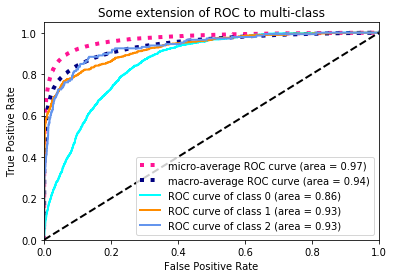

In [367]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

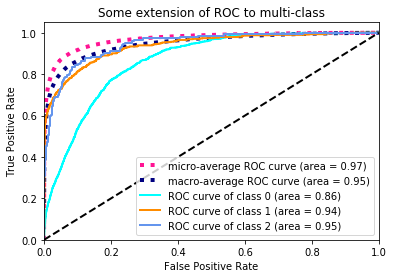

In [368]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [382]:
def train_classifier(X_train, y_train, penalty):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    OVR = OneVsRestClassifier(LogisticRegression(penalty = penalty))
    OVR.fit(X_train, y_train)
    return OVR

In [383]:
classifier_mybag = train_classifier(X_train_mybag, y_train,"l1")
classifier_tfidf = train_classifier(X_train_tfidf, y_train,"l1")

C:\Users\Cagri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Cagri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [384]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [385]:
print('Bag-of-words\n')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('\nTfidf\n')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words

	accuracy: 0.364 
	F1: 0.656 
	AUC: 0.714 
	AUC precision: 0.356

Tfidf

	accuracy: 0.365 
	F1: 0.652 
	AUC: 0.706 
	AUC precision: 0.349


When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [386]:
test_predictions = classifier_mybag.predict(X_test_mybag)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = # top-5 words sorted by the coefficiens.
    top_negative_words = # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [ ]:
grader.status()

In [ ]:
STUDENT_EMAIL = # EMAIL 
STUDENT_TOKEN = # TOKEN 
grader.status()

If you want to submit these answers, run cell below

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)